In [2]:
#load dependencies 
import pandas as pd
import numpy as np
from fredapi import Fred
from config import key, pwrd, aws_access, aws_secret
from tqdm import tqdm, tqdm_notebook
import warnings
import time
from sqlalchemy import create_engine
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
import boto3
from botocore.exceptions import NoCredentialsError



In [3]:
#s3 paramaters
region = 'us-east-2'
access_key = aws_access
secret_key = aws_secret

In [4]:
#upload to S3 function
def upload_to_aws(local_file, bucket, s3_file):
    s3 = boto3.client('s3', aws_access_key_id=access_key,
                      aws_secret_access_key=secret_key)

    try:
        s3.upload_file(local_file, bucket, s3_file)
        print("Upload Successful")
        return True
    except FileNotFoundError:
        print("The file was not found")
        return False
    except NoCredentialsError:
        print("Credentials not available")
        return False




In [5]:
#S3 upload test
# upload_to_aws('data/PAYEMS.csv', 'astoria-adv', 'PAYEMS.csv')

In [6]:
#SQL connection to AWS RDS
rds_connection_string = "postgres:"+ pwrd + "@big-data-2.cpclfqan17p9.us-east-1.rds.amazonaws.com/econ_data"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [7]:
#RDS upload test
#spx_chart.to_sql(name='test', con=engine, if_exists='replace', index=True)

In [8]:
#RDS test
# engine.table_names()

In [9]:
#define FRED API call
fred = Fred(api_key= key)

In [10]:
#set column view options
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 50)

In [11]:
# Code to search FRED database
# search = fred.search('500', order_by='popularity', sort_order='desc')
# search_df = pd.DataFrame(search[['title', 'id', 'popularity', 'units','seasonal_adjustment_short']])
# search_df[:20]

In [12]:
#desired indicators
indicators = ['USSLIND', 'UMCSENT', 'CSCICP03USM665S', 'INDPRO', 'TCU','DGORDER', 'NEWORDER', 'PI','BUSINV', 'TOTALSA',
             'MARTSMPCSM44X72USS', 'PAYEMS', 'UNRATE', 'ICSA', 'CCSA', 'CC4WSA', 'NPPTTL', 'CES0500000003', 'HSN1F',
             'EXHOSLUSM495S', 'PERMIT', 'CSUSHPINSA', 'SP500']

In [13]:
print(f'{len(indicators)} indicators to download')

23 indicators to download


In [14]:
#set start date
date = input("Choose start date in mm/dd/yyyy format")

Choose start date in mm/dd/yyyy format01/02/2020


In [15]:
#create FRED dataframe function
def fred_df(series):
    data =  fred.get_series(series, observation_start= date)
    info = fred.get_series_info(series)
    data_df = pd.DataFrame(data)
    data_df.reset_index(level=0, inplace=True)
    info_df = pd.DataFrame(info)
    info_df.reset_index(level=0, inplace=True)
    #pivot info_df
    df_dict = dict(zip(info_df['index'],info_df[0]))
    info_df = pd.DataFrame(df_dict,  index=[0])
    #duplicate info_df rows to equal data_df length
    info_df = pd.concat([info_df]*(len(data_df)), ignore_index=True)
    global combine_df
    #join df's
    combine_df = data_df.join(info_df)
    #rename columns
    combine_df.rename(columns = {'index':'date', 0:'data'}, inplace = True) 
    #create new 'change from last column'
    combine_df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    combine_df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [combine_df.iloc[i,1]-combine_df.iloc[i-1,1] for i in range (1,len(combine_df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    combine_df['change'][1:len(combine_df)] = change_clean
    #create pct_change column
    combine_df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    combine_df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [(combine_df.iloc[i,1]/combine_df.iloc[i-1,1] - 1) *100 for i in range(1,len(combine_df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    combine_df['pct_change'][1:len(combine_df)] = pct_clean

In [16]:
#create df for spx
fred_df('SP500')
spx_df = combine_df


In [17]:
#function to make charts monthly and plot monthly change
def monthly(df):
    #make date col the index
    df = df.reset_index().set_index('date')
    #resample df to Monthly Business freq, take last value
    df = df.resample('BM').last()
    #reset index
    df.reset_index(level=0, inplace=True)
    #drop old change, pct_change and index 
    df.drop(['change','pct_change', 'index'], axis=1, inplace=True)
    #re-calc change and pct_change
    #create new 'change from last column'
    df.insert(2, 'change', np.nan)
    #fill nan with zeroes
    df['change'].fillna(0, inplace=True)
    #create data for 'change' column
    changes = [df.iloc[i,1]-df.iloc[i-1,1] for i in range (1,len(df))]
    change_clean = [float("{0:.3f}".format(x)) for x in changes]
    df['change'][1:len(df)] = change_clean
    #create pct_change column
    df.insert(3,'pct_change',np.nan)
    #fill nan with zeroes
    df['pct_change'].fillna(0, inplace=True)
    #create data for pct_change col
    pct_change = [(df.iloc[i,1]/df.iloc[i-1,1] - 1) * 10 for i in range(1,len(df))]
    pct_clean = [float("{0:.3f}".format(x)) for x in pct_change]
    df['pct_change'][1:len(df)] = pct_clean
    #change frequency
    df.replace({'frequency': 'Daily, Close'}, 'Monthly, Close', inplace=True)
    df.replace({'frequency_short': 'D'}, 'M', inplace=True)
    global month_df
    month_df = df

    return month_df.head()
    
    
    

In [18]:
#make monthly SPX dataframe
monthly(spx_df)
spx_month_df = month_df


In [19]:
errors=[]
for indicator in tqdm_notebook(indicators):
    try:
        #get data and info series
        fred_df(indicator)
        combine_df.to_csv(f"data/{indicator}.csv",index = False, header = True)
        #export data to SQL
        combine_df.to_sql(name= indicator, con=engine, if_exists='replace', index=True)
        spx_chart = spx_month_df
    except Exception as e: 
        print(f'error with {indicator} data. Proceeding...')
        print(e)
        errors.append(indicator)

error with USSLIND data. Proceeding...
Failed to upload images/USSLIND_line.png to astoria-adv/USSLIND_line.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.
error with UMCSENT data. Proceeding...
Failed to upload images/UMCSENT_line.png to astoria-adv/UMCSENT_line.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.
error with CSCICP03USM665S data. Proceeding...
Failed to upload images/CSCICP03USM665S_line.png to astoria-adv/CSCICP03USM665S_line.png: An error occurred (SignatureDoesNotMatch) when calling the PutObject operation: The request signature we calculated does not match the signature you provided. Check your key and signing method.
error with INDPRO data. Proceeding...
Failed to upload 

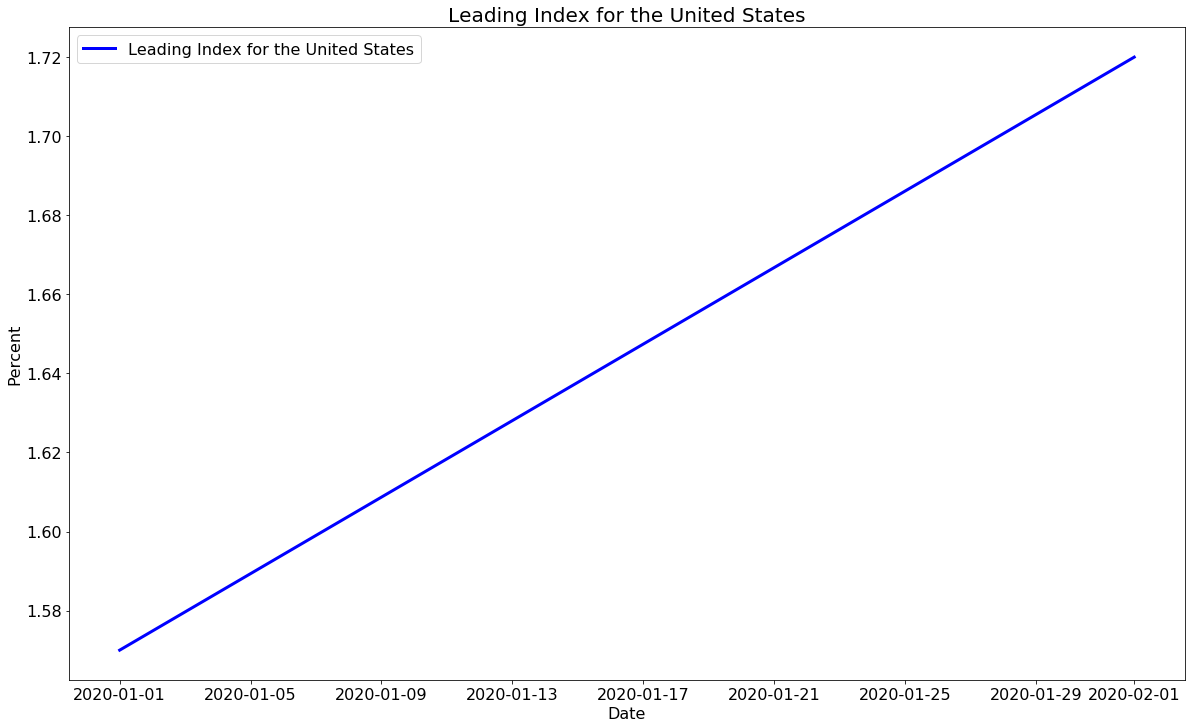

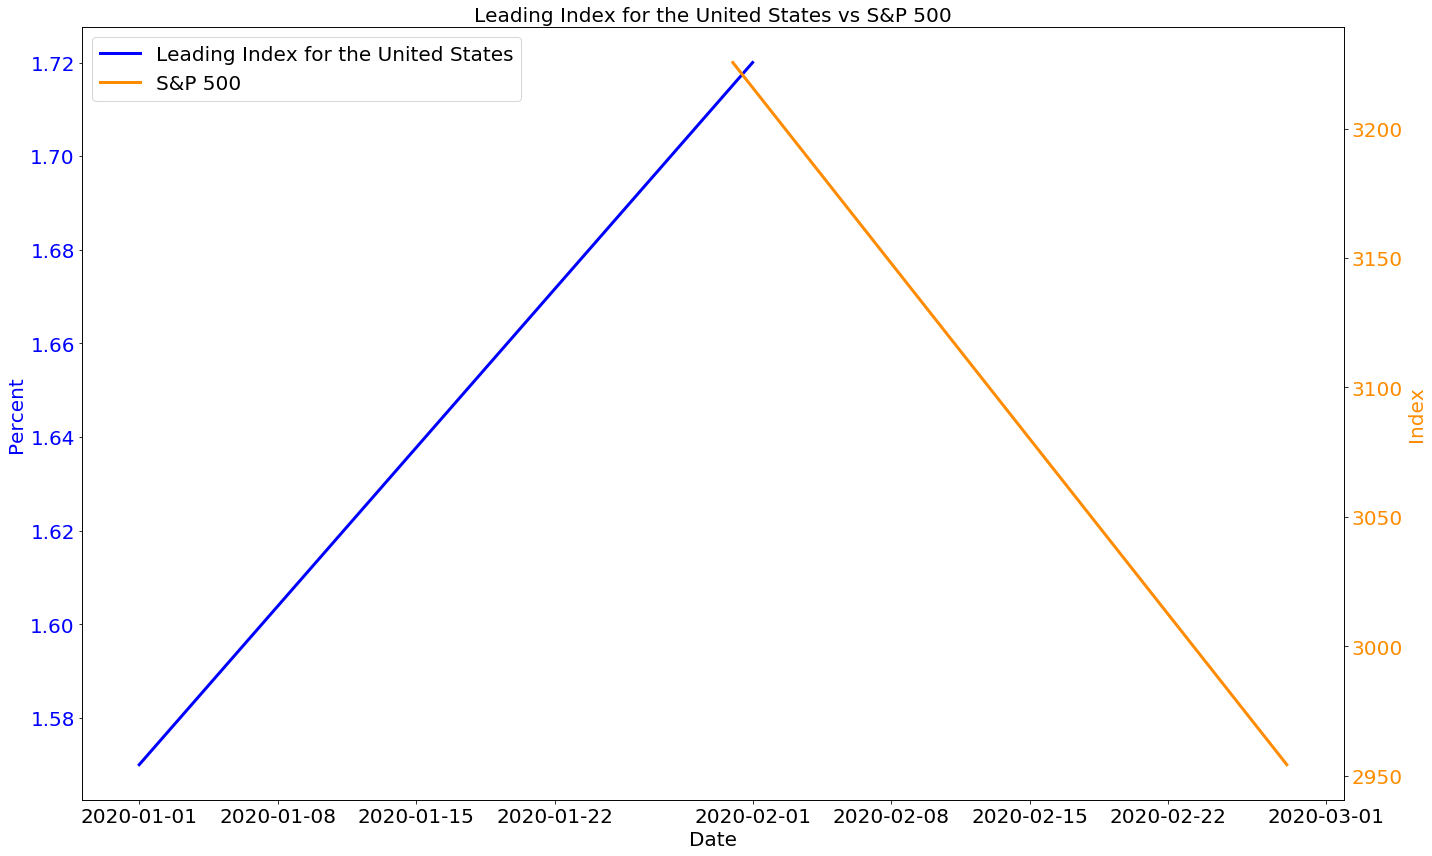

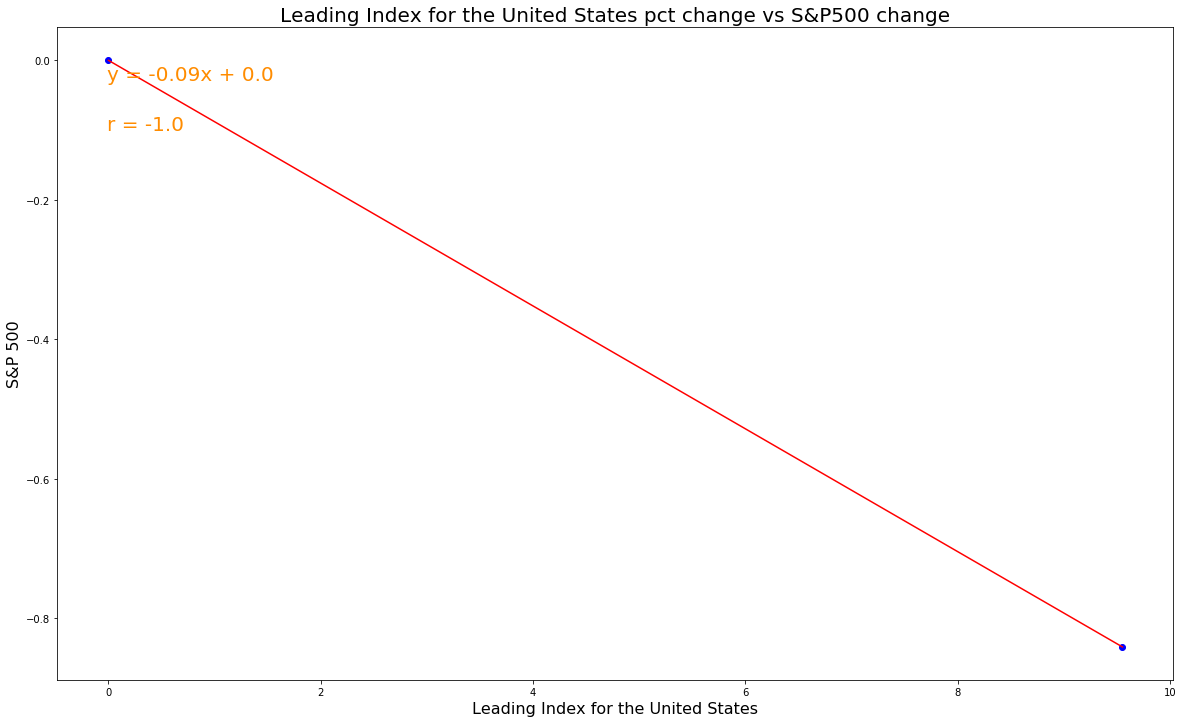

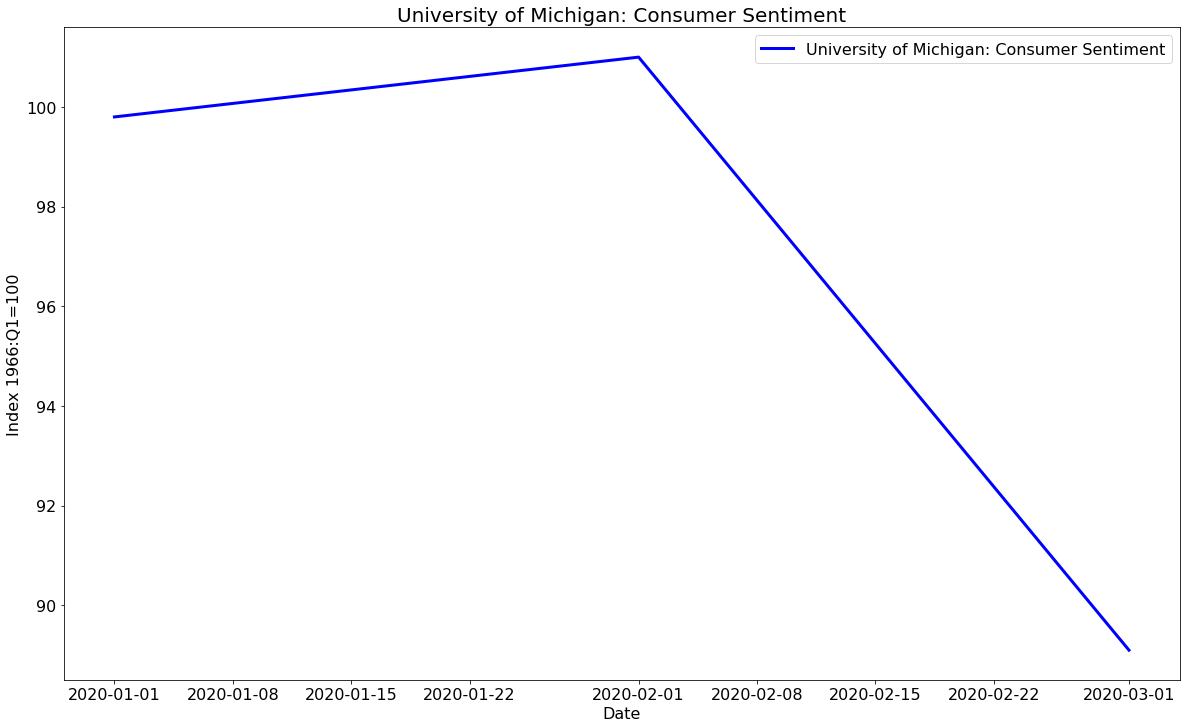

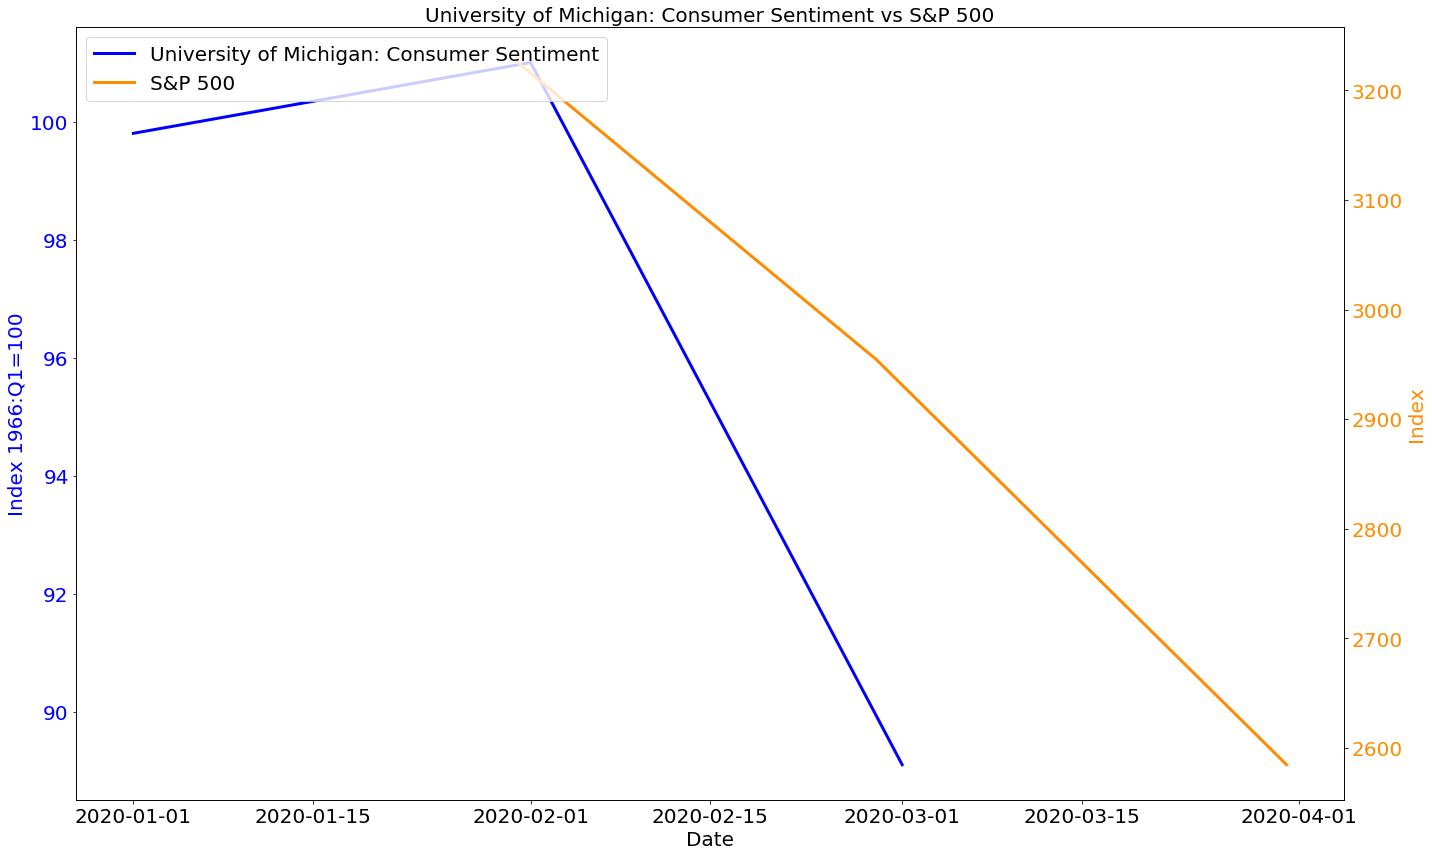

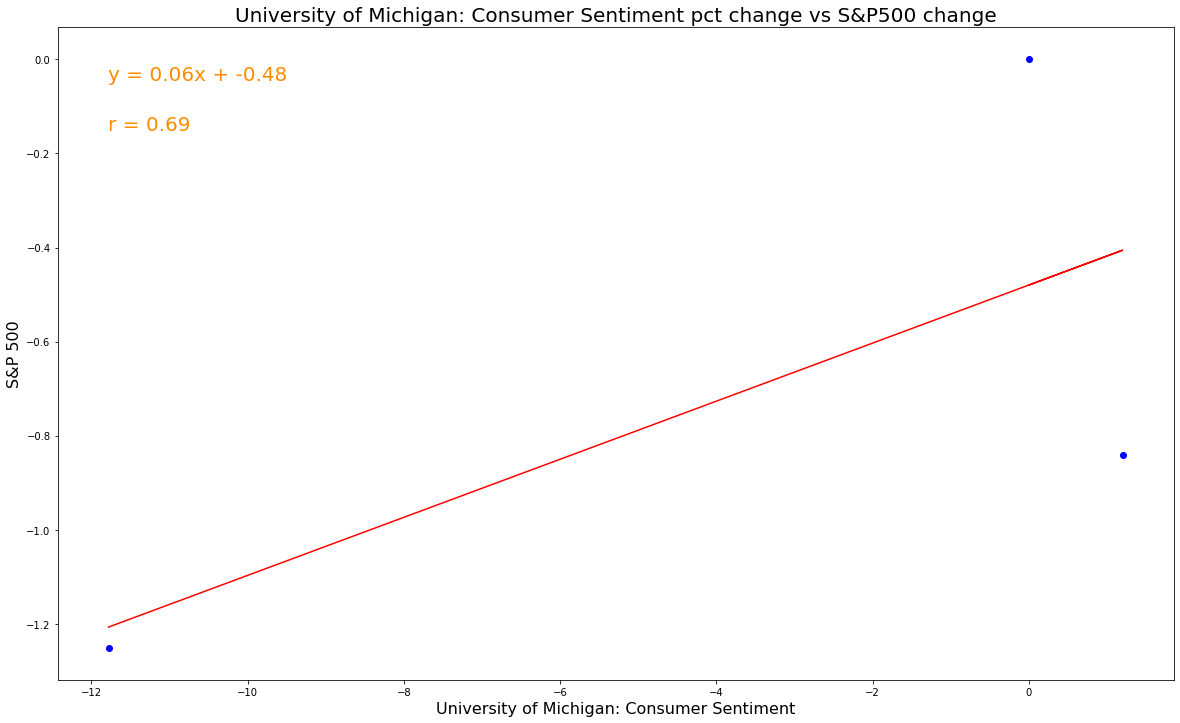

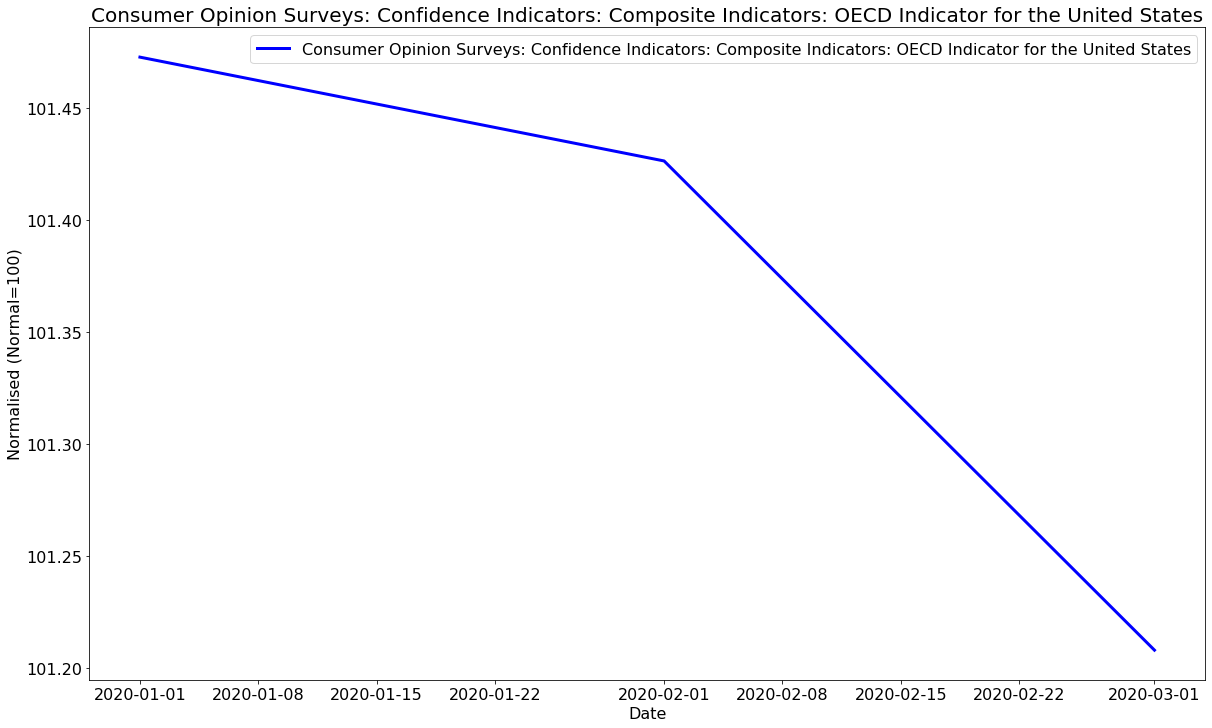

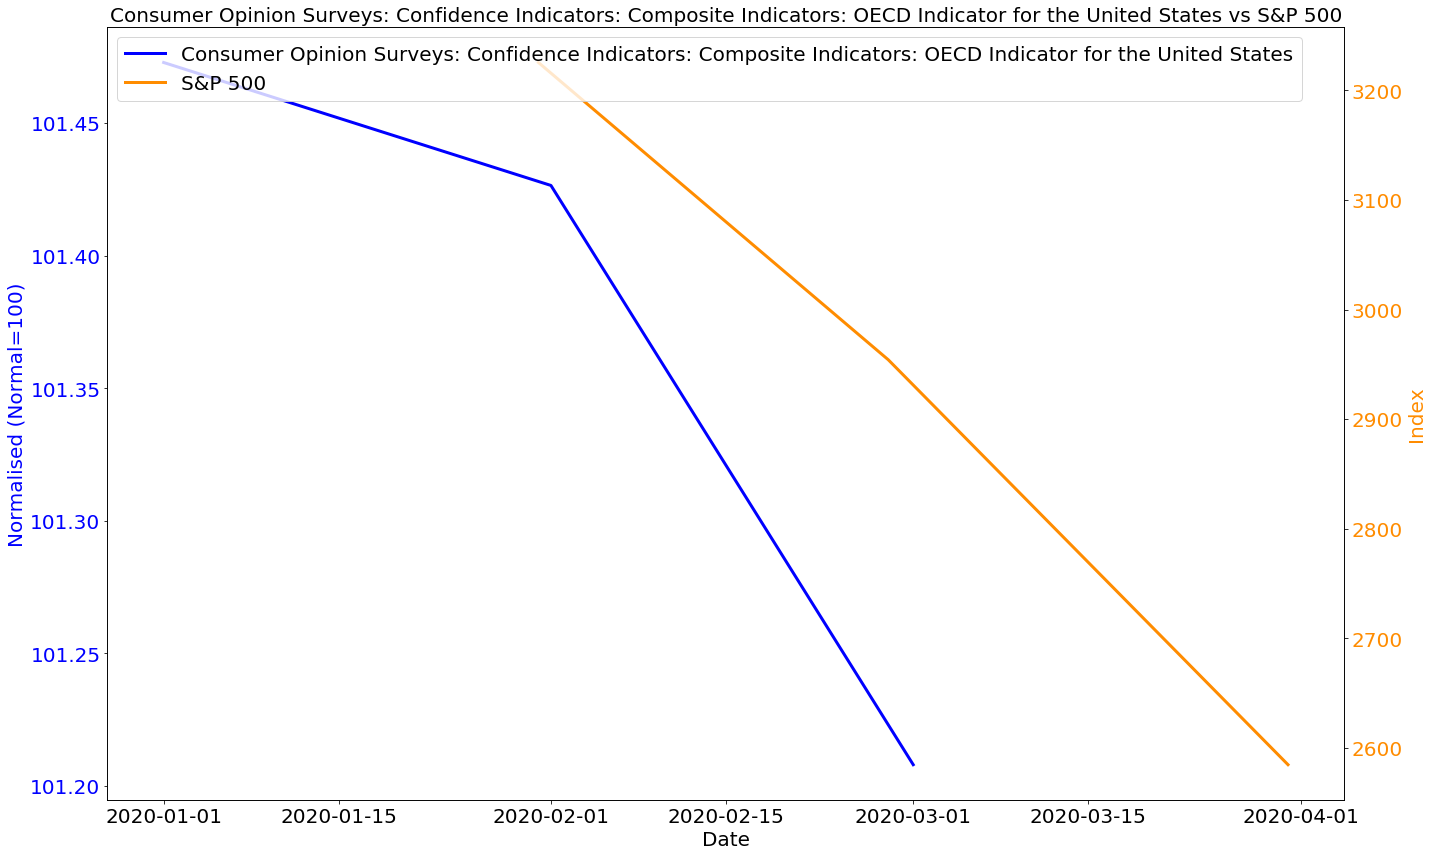

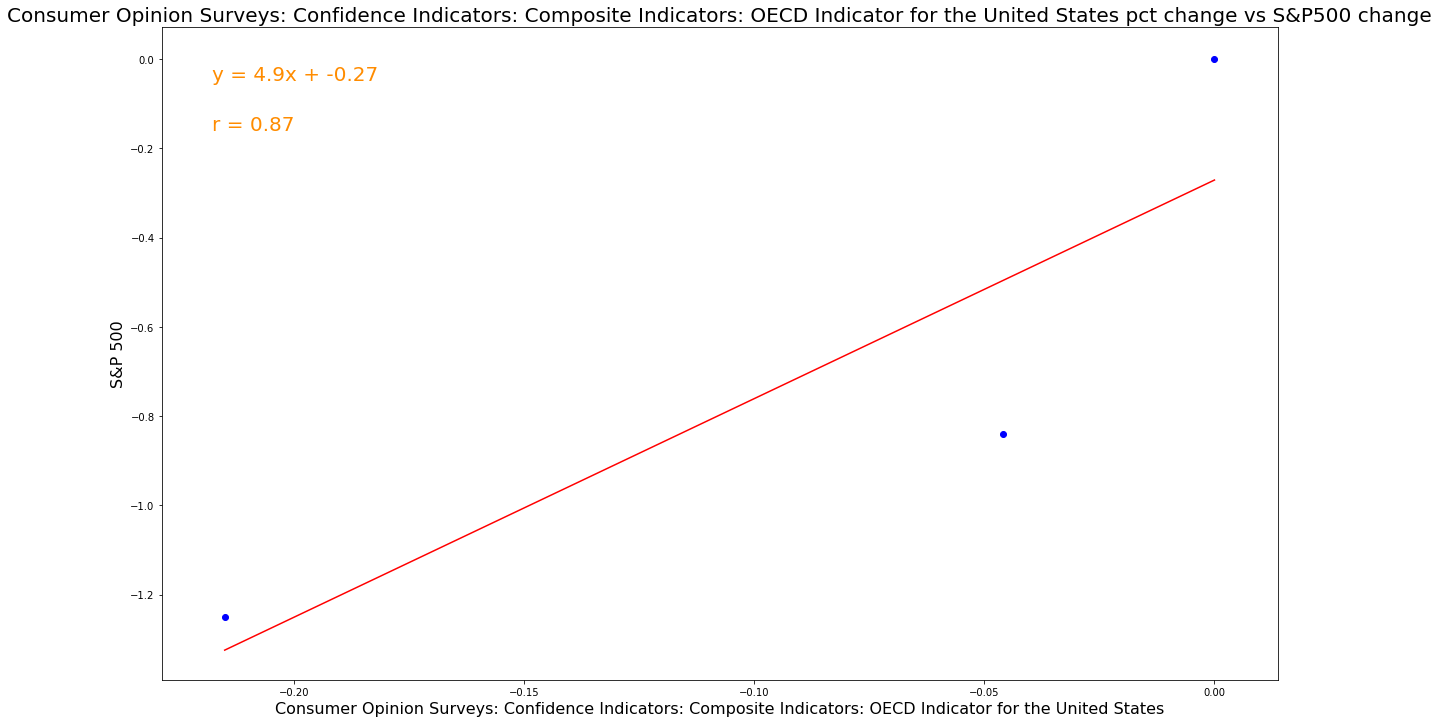

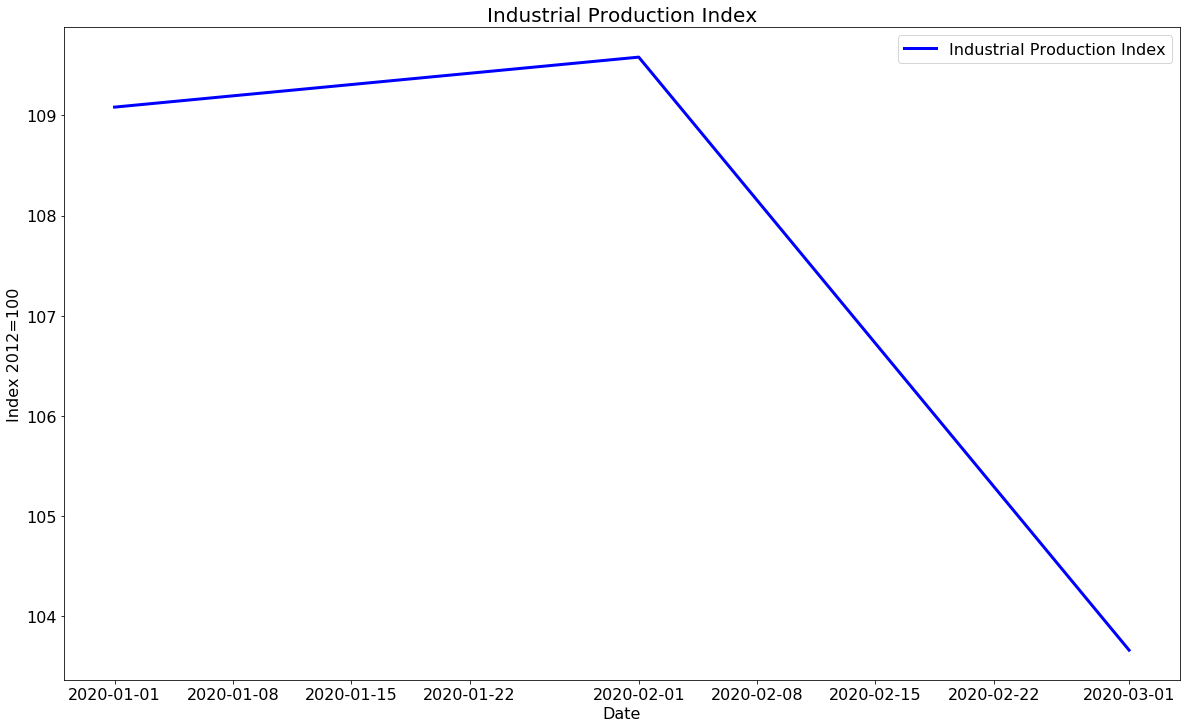

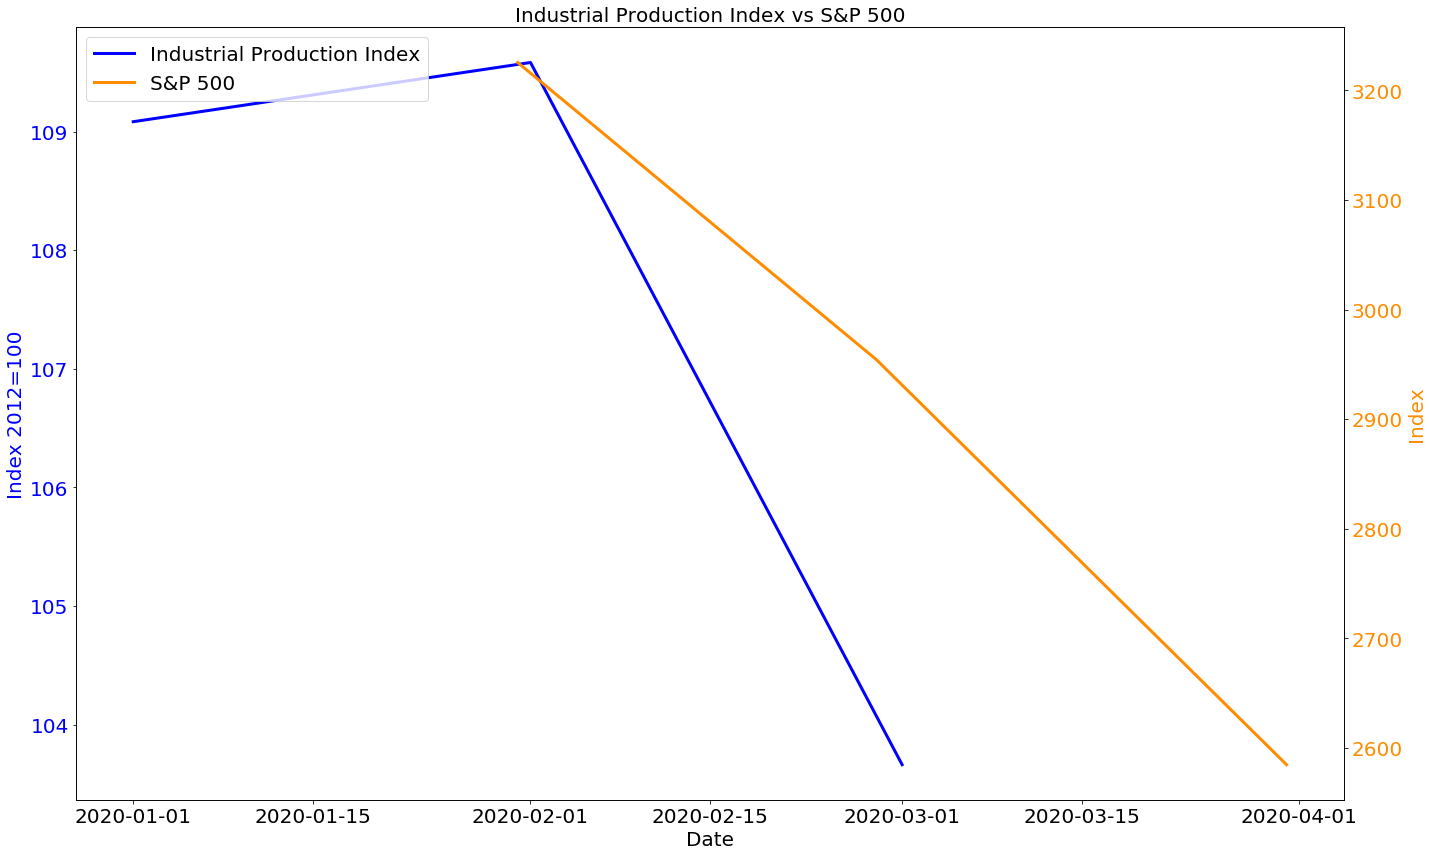

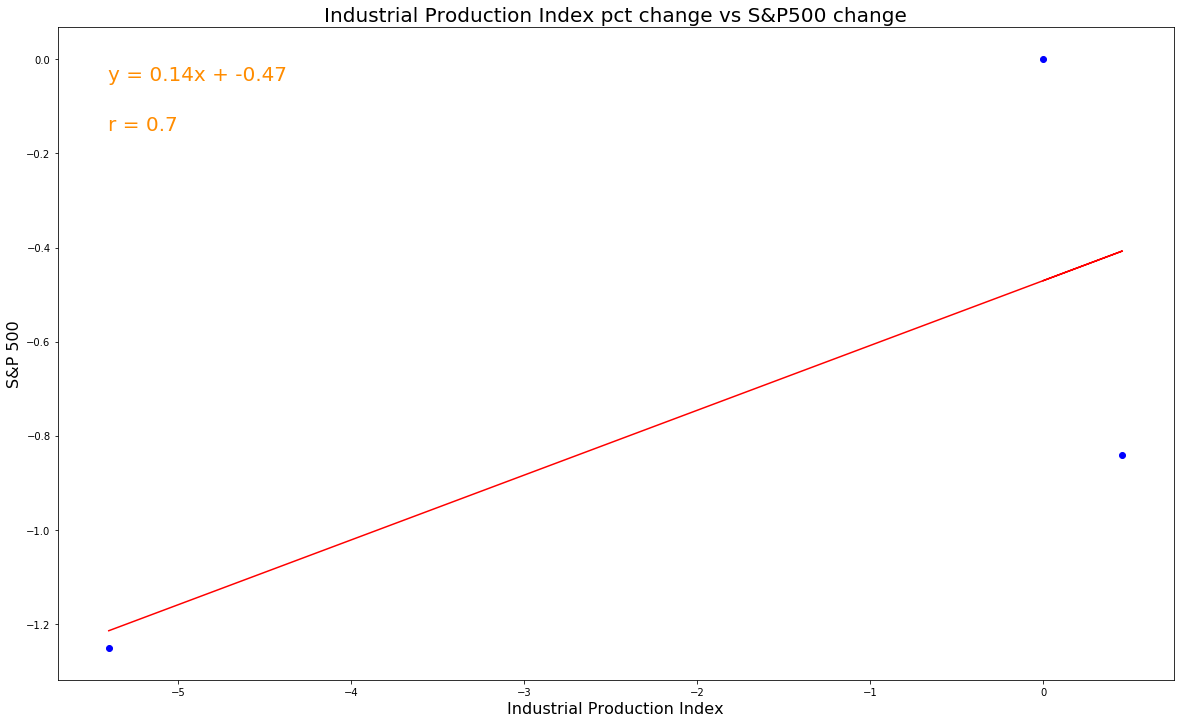

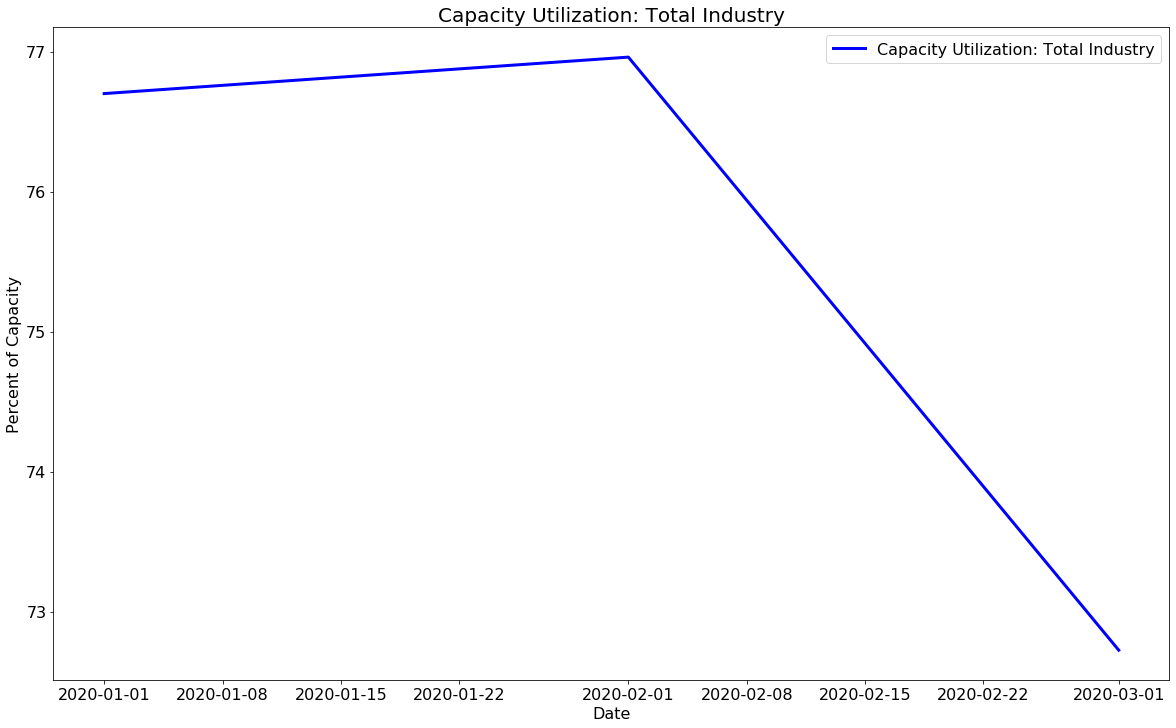

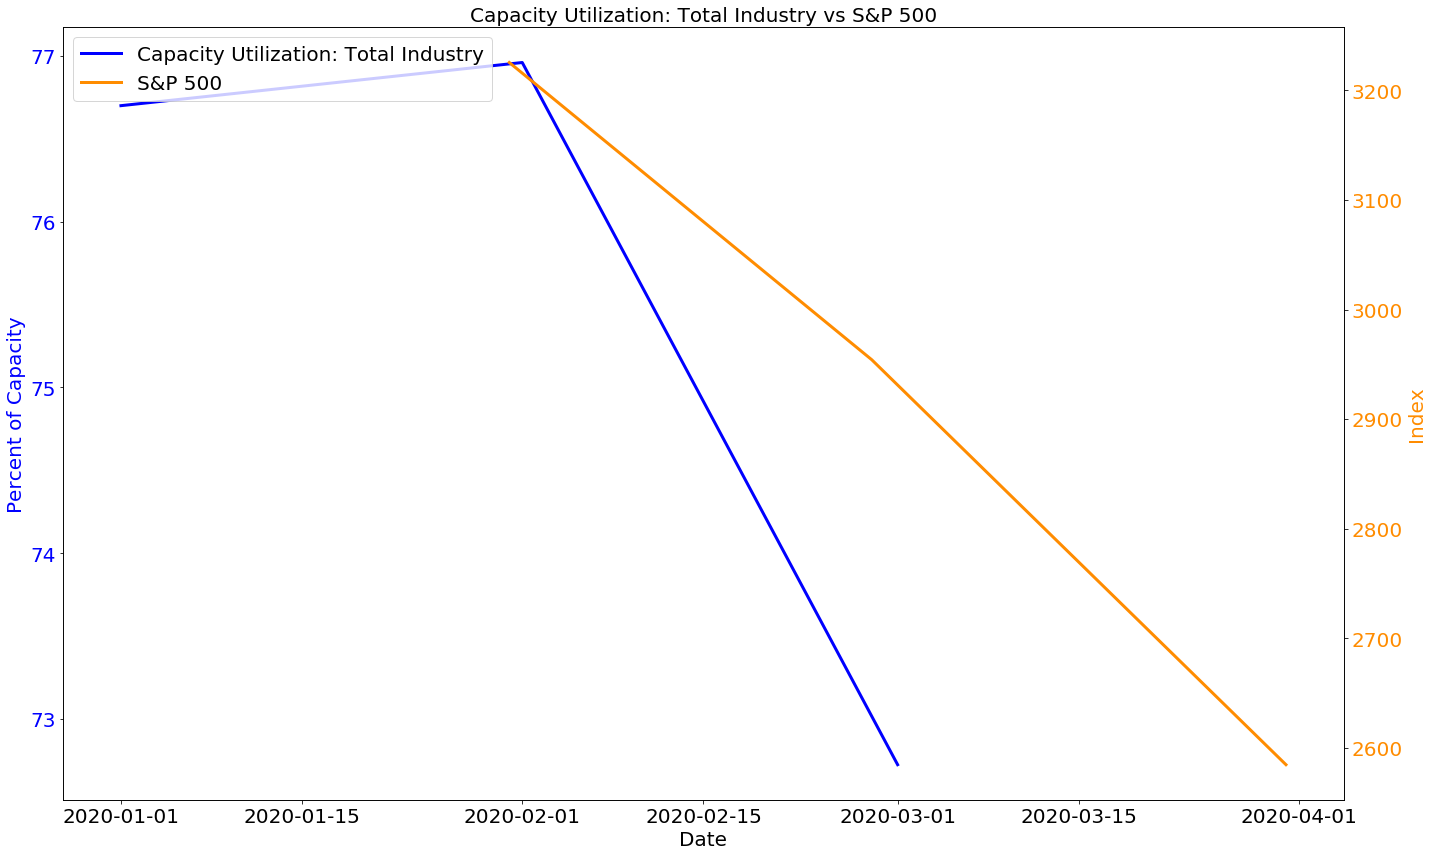

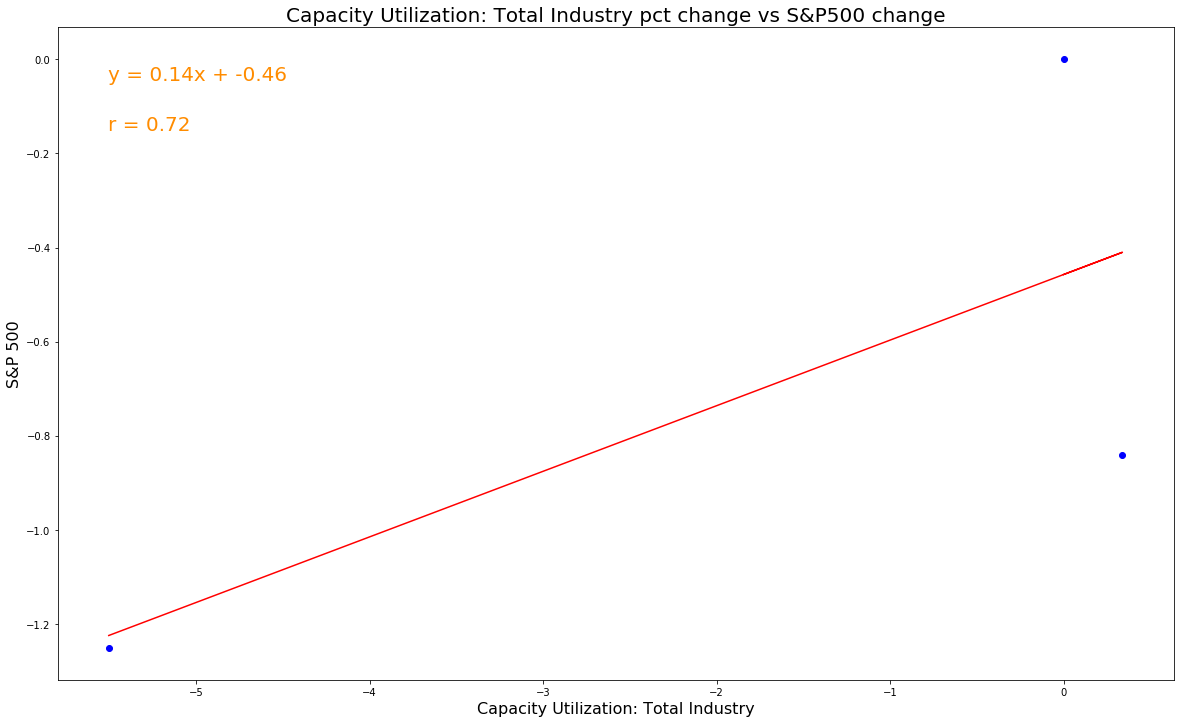

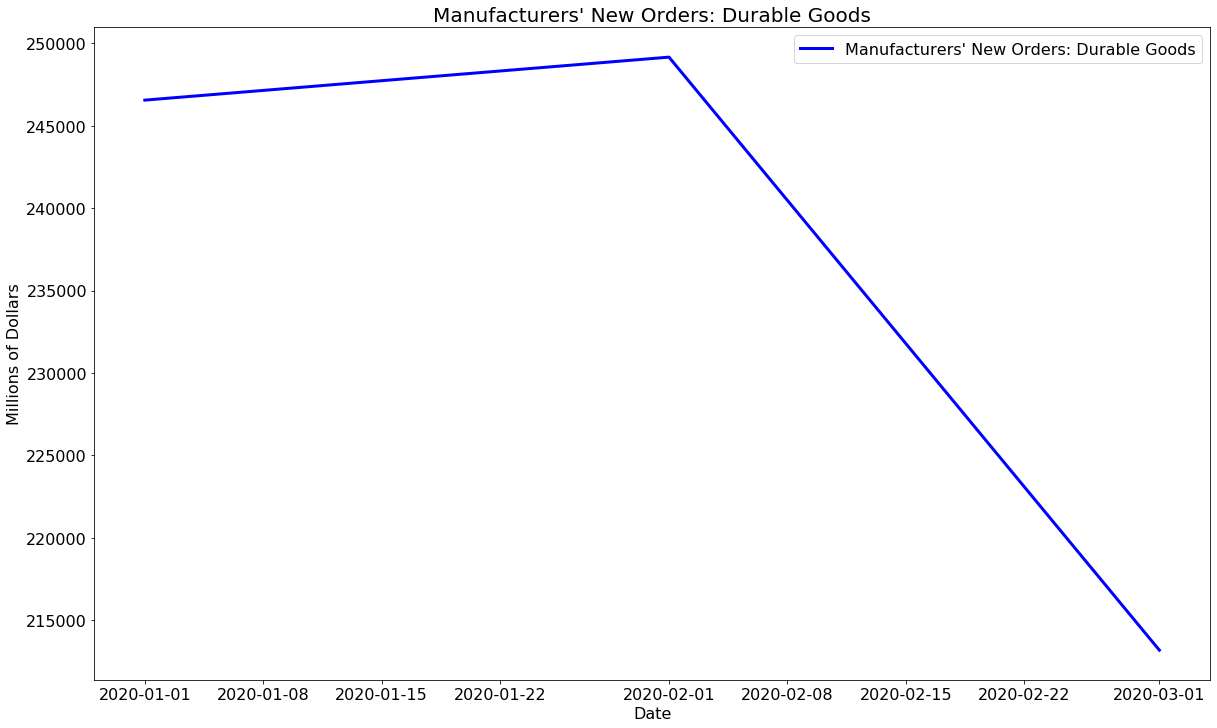

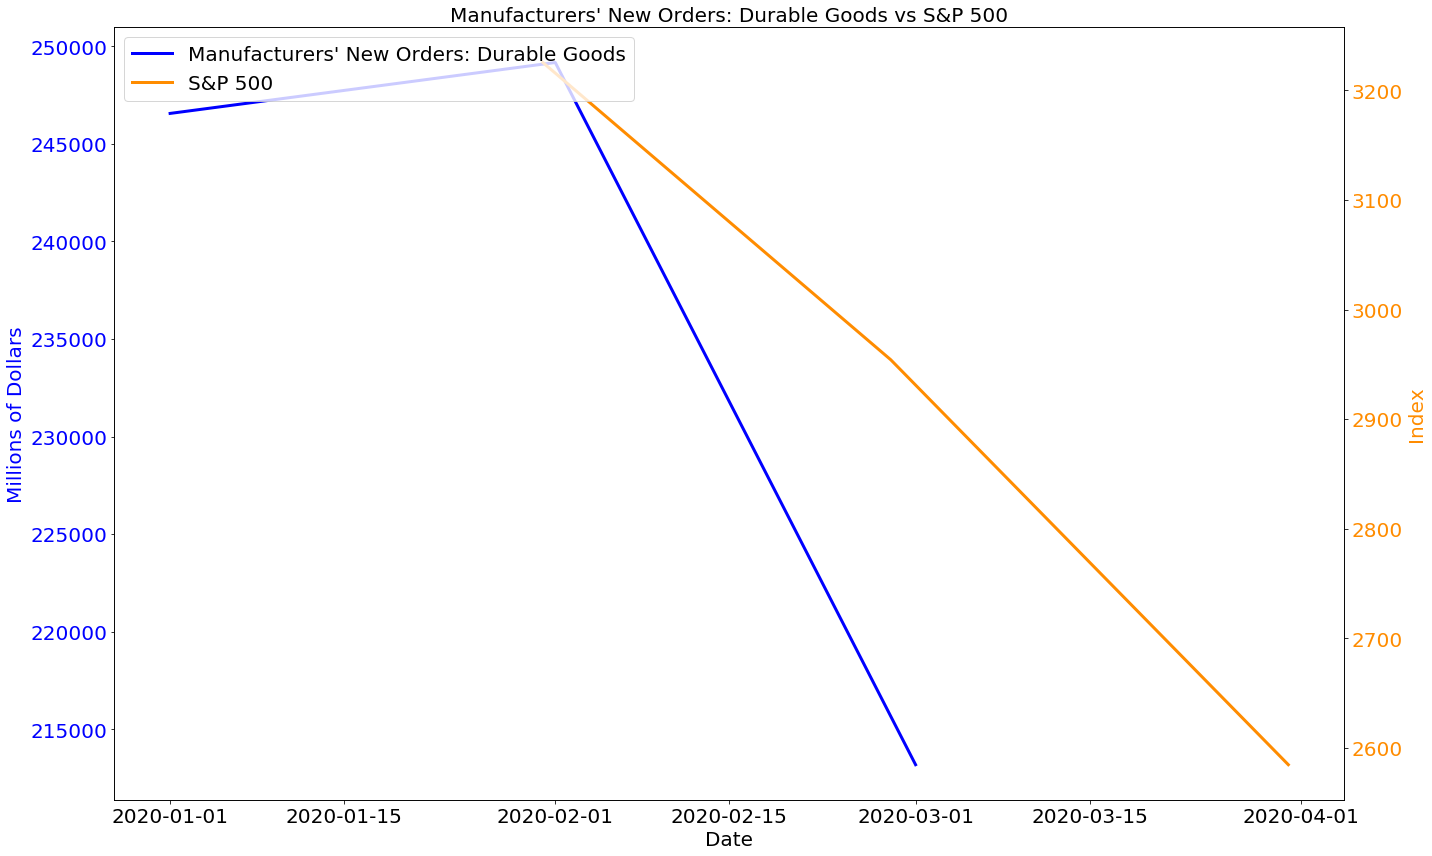

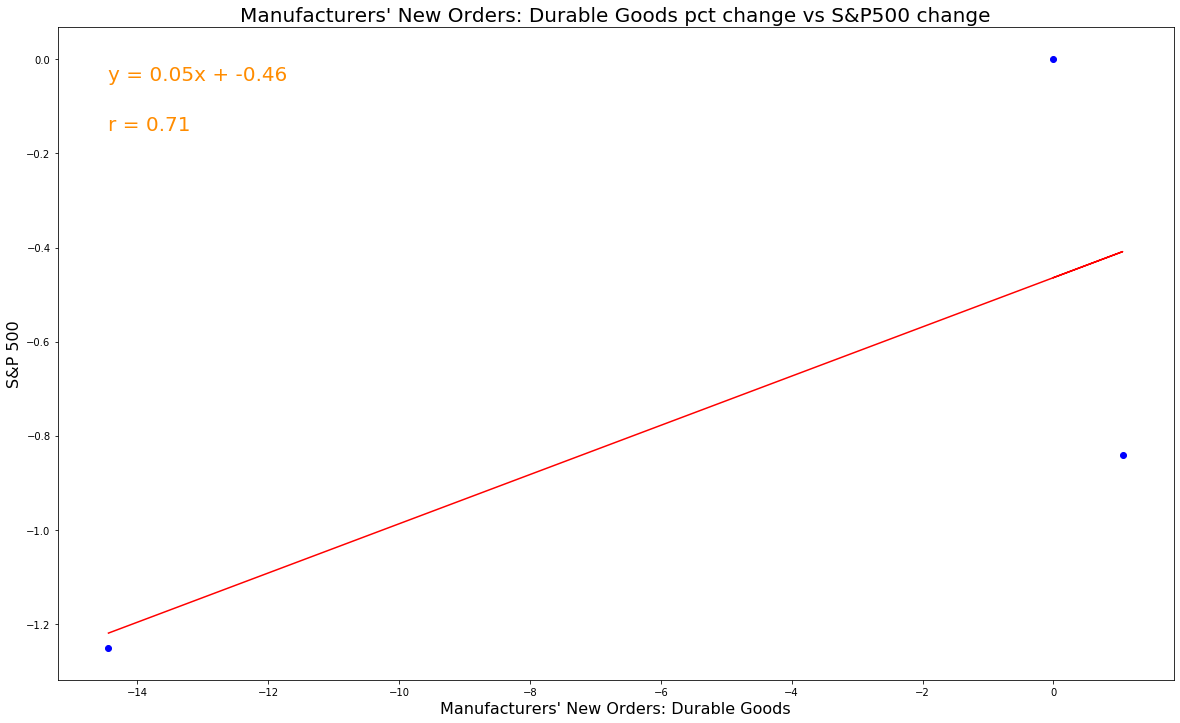

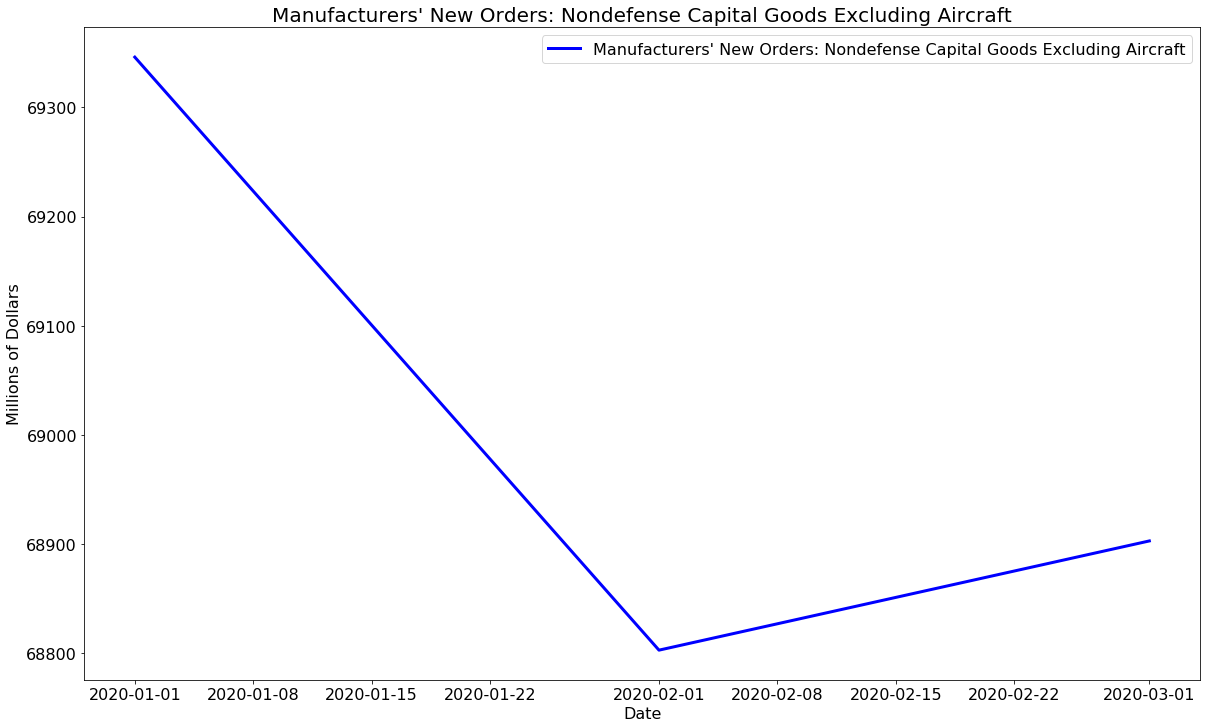

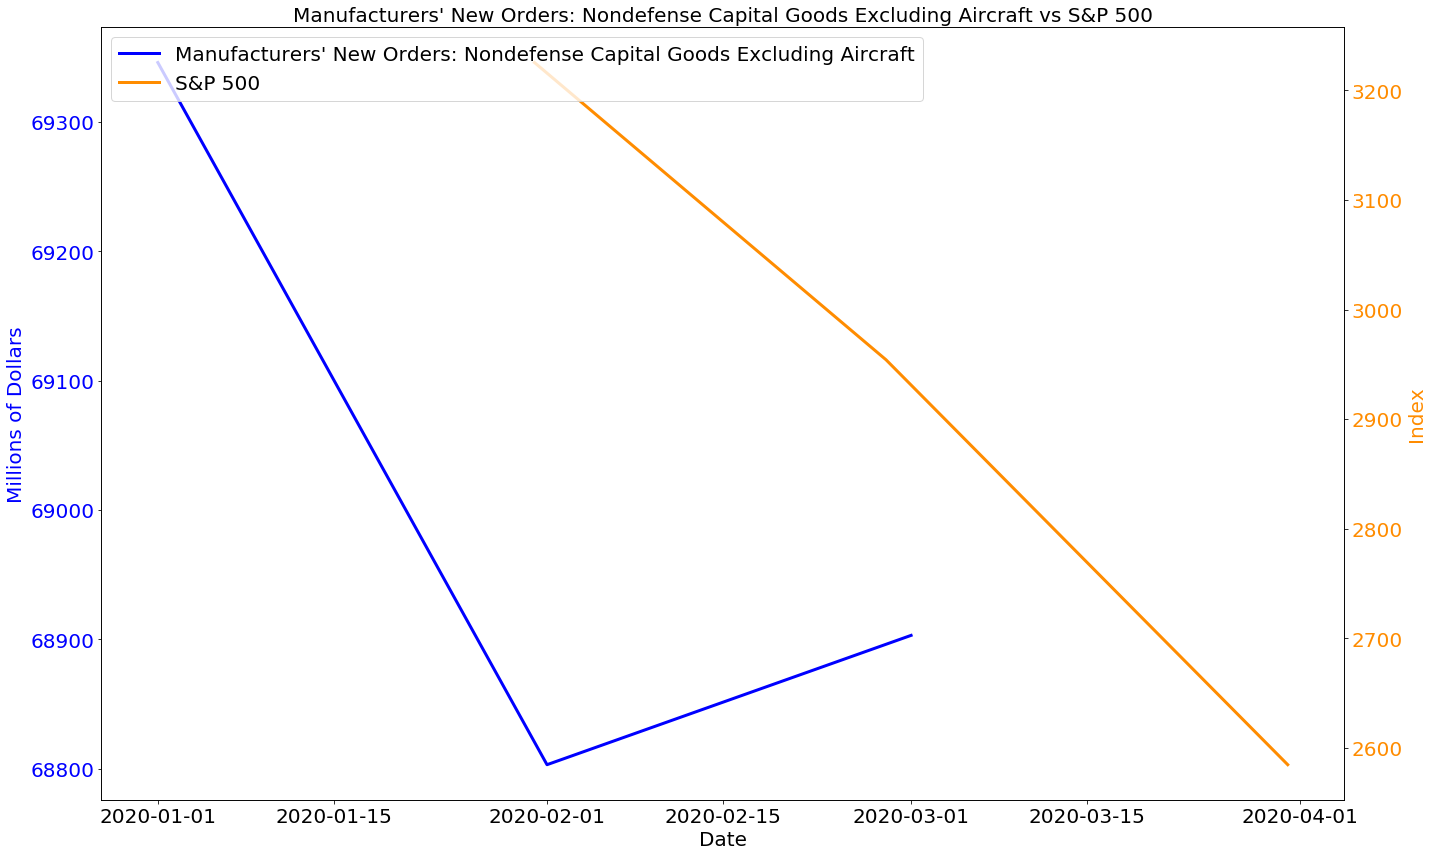

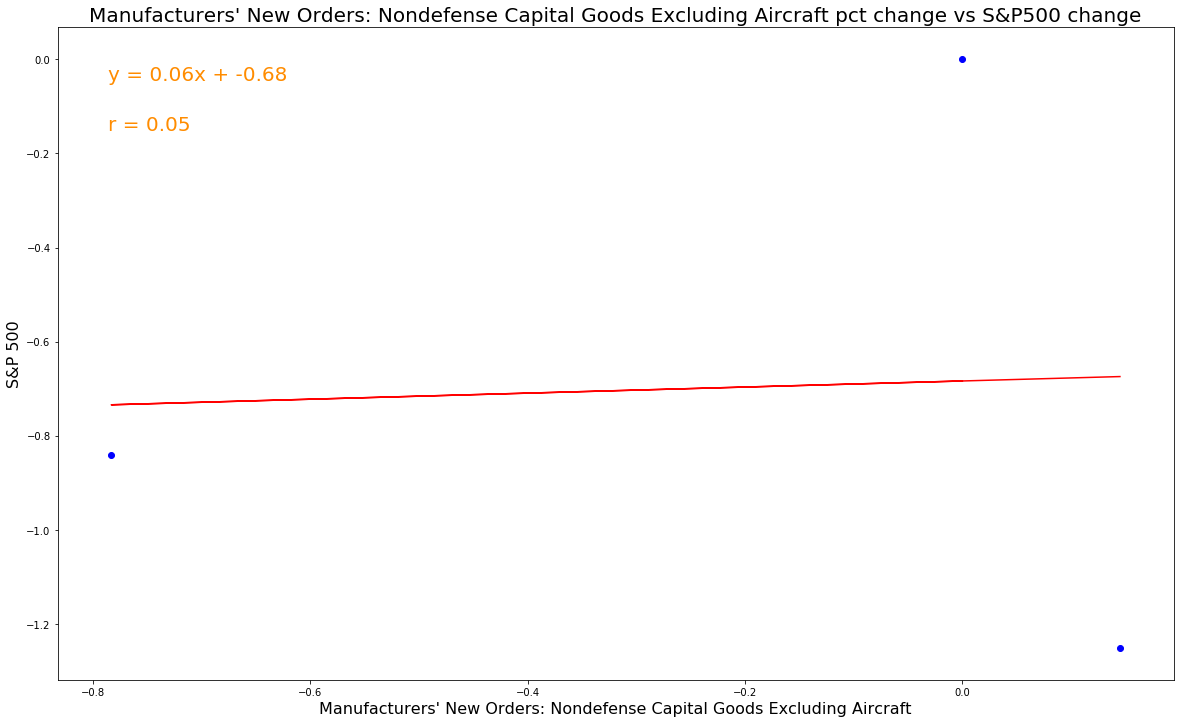

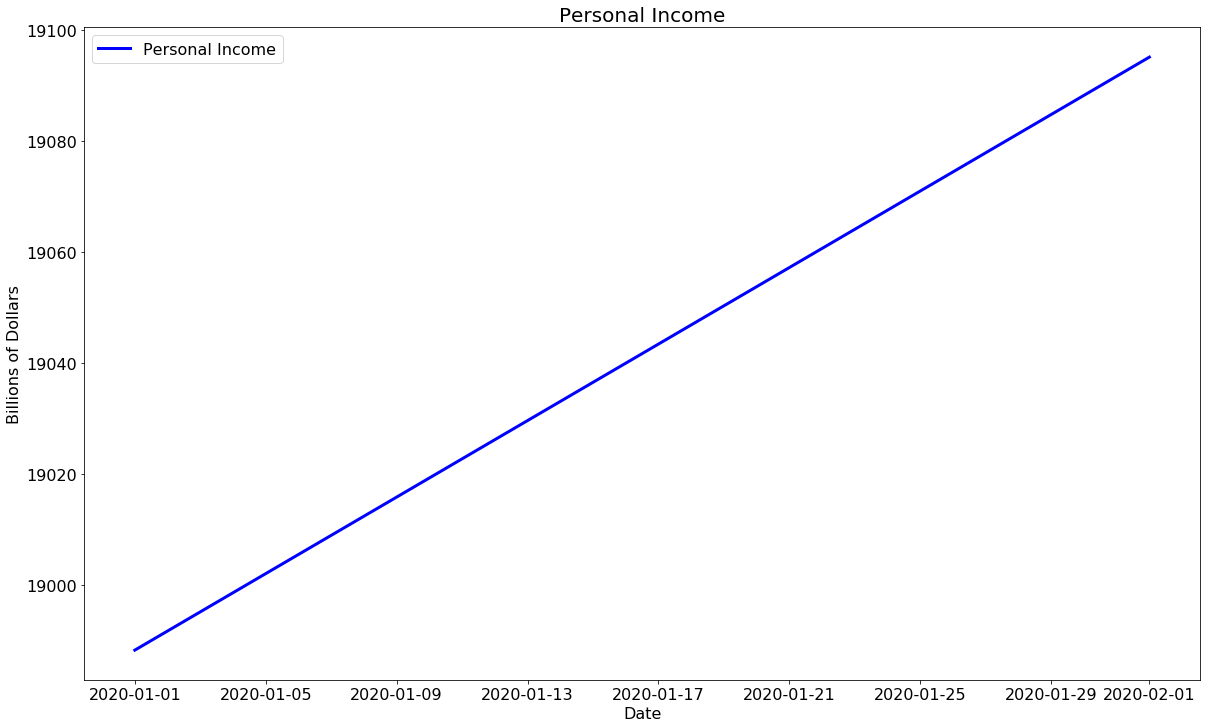

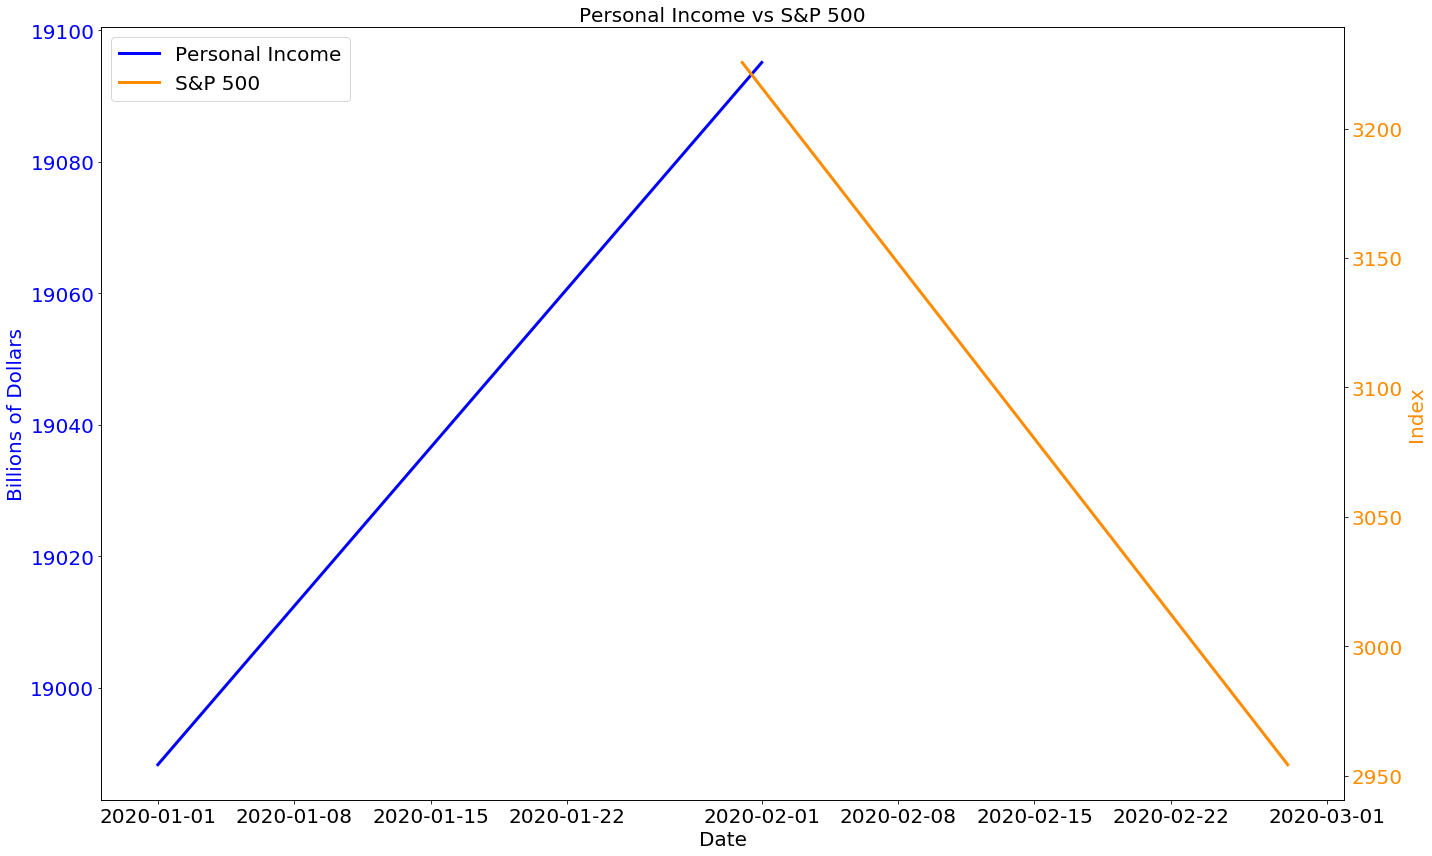

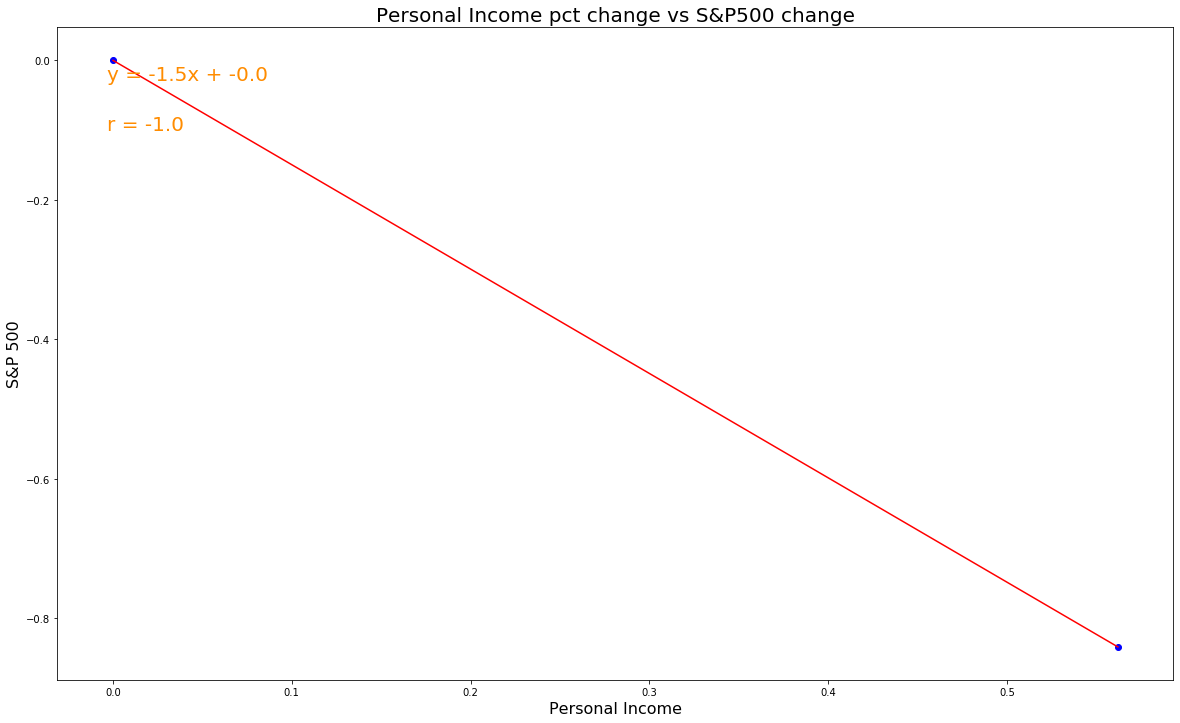

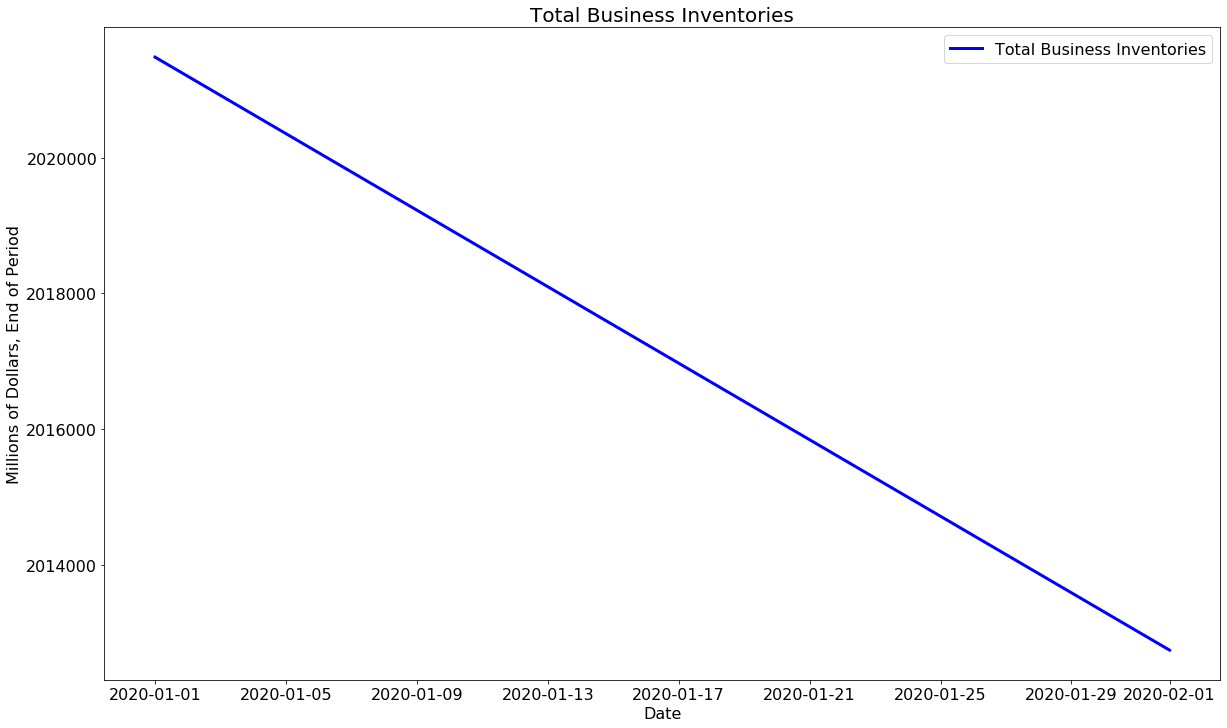

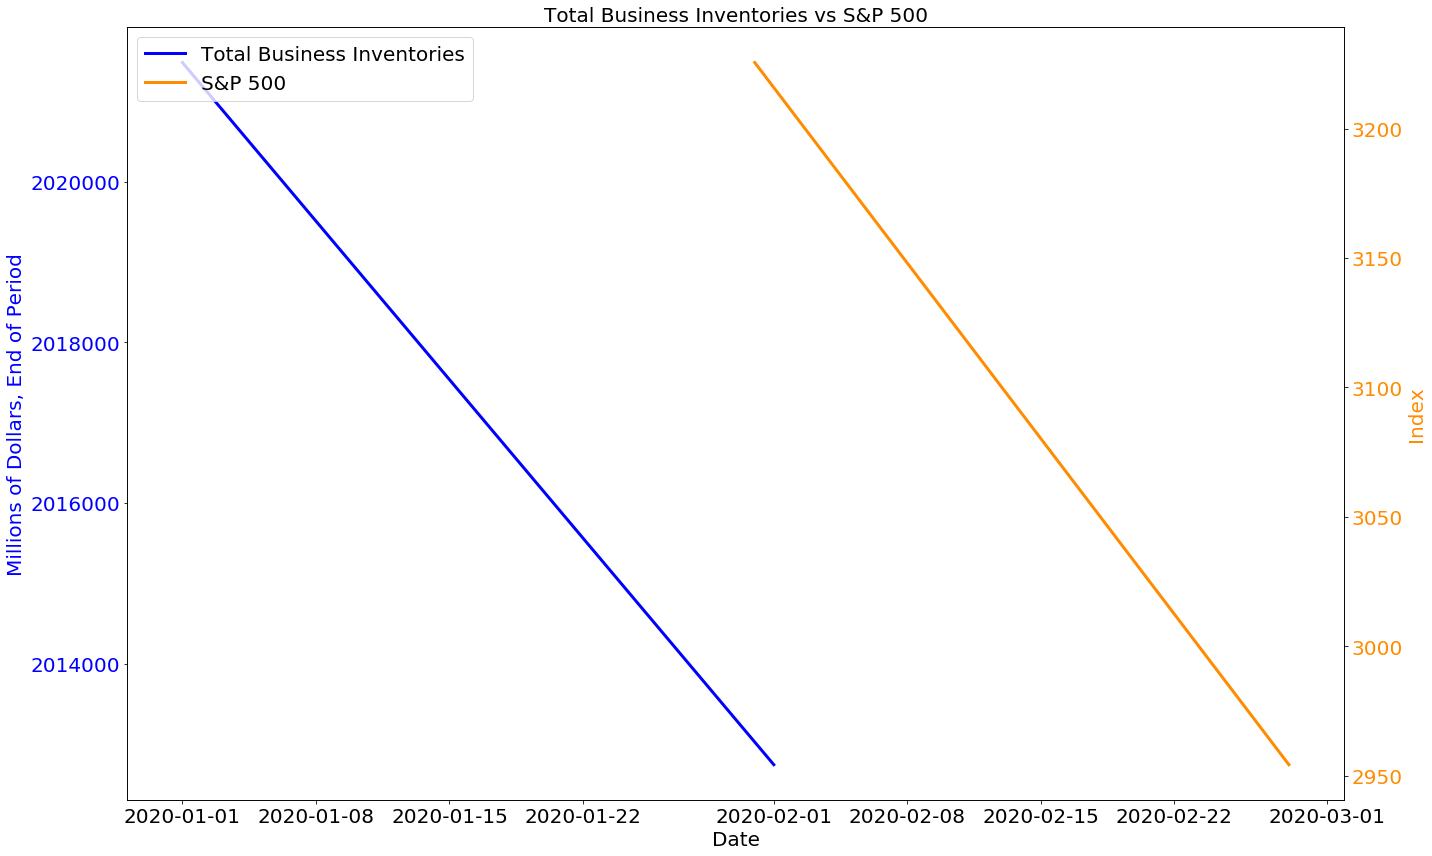

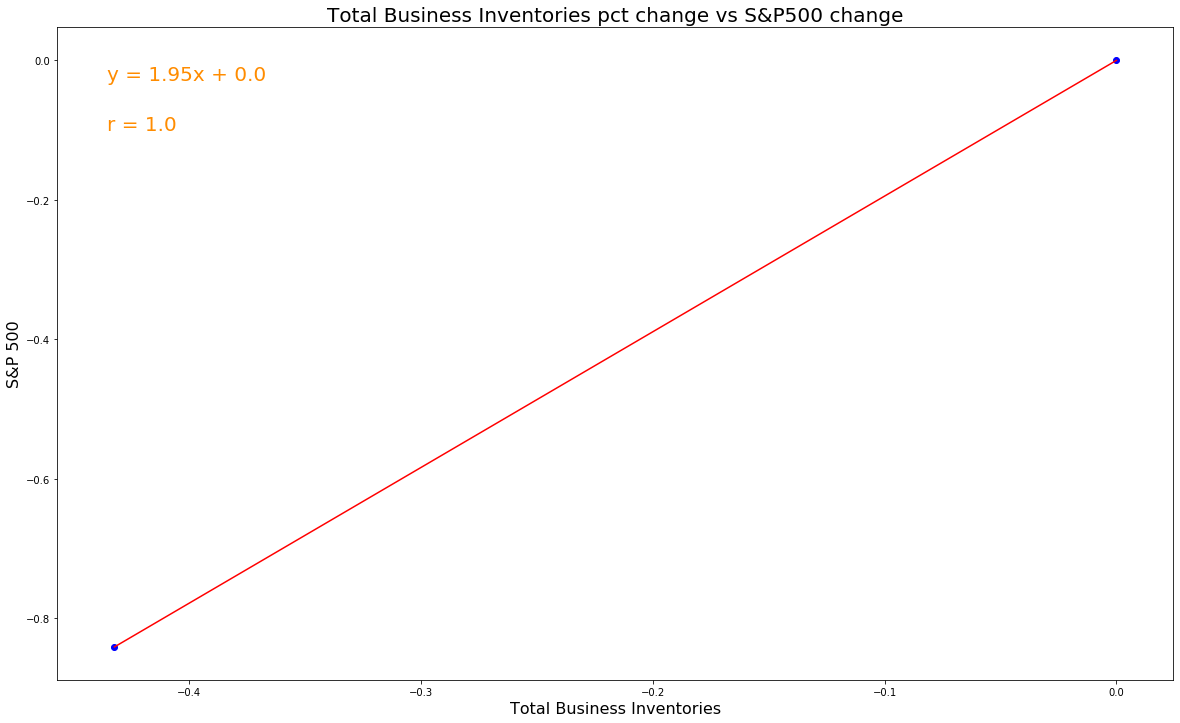

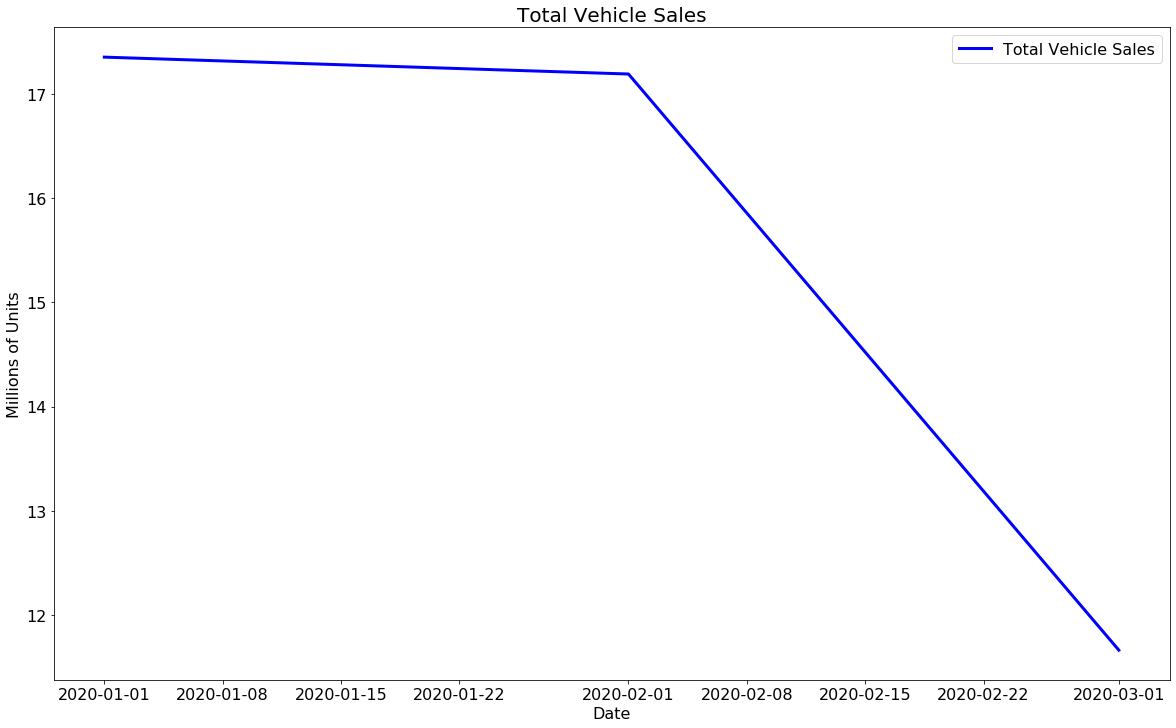

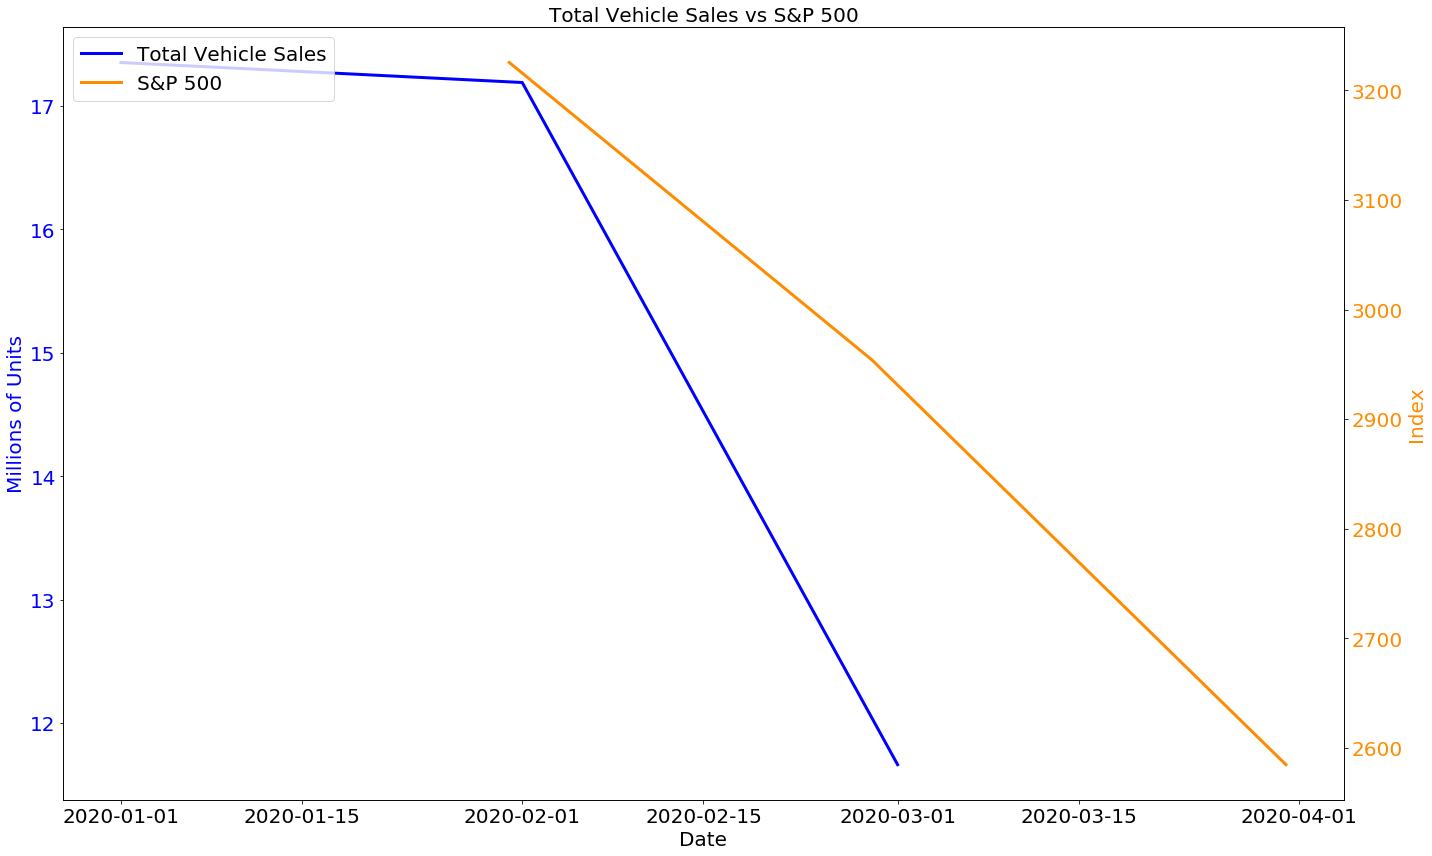

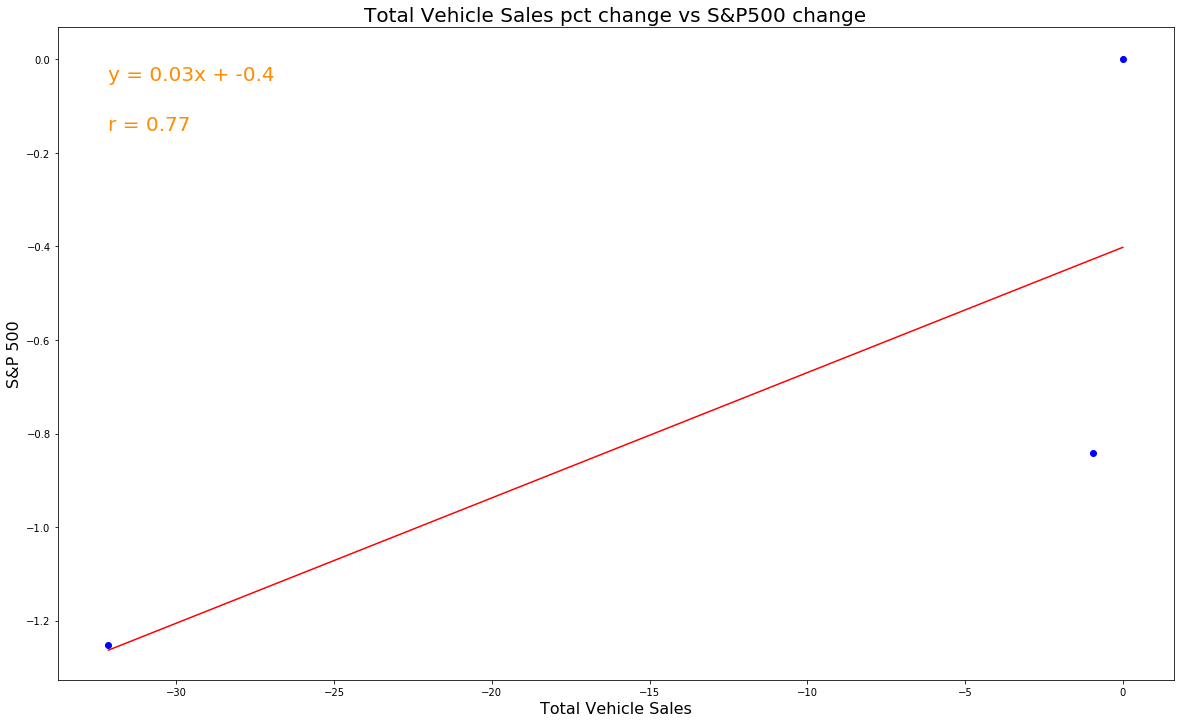

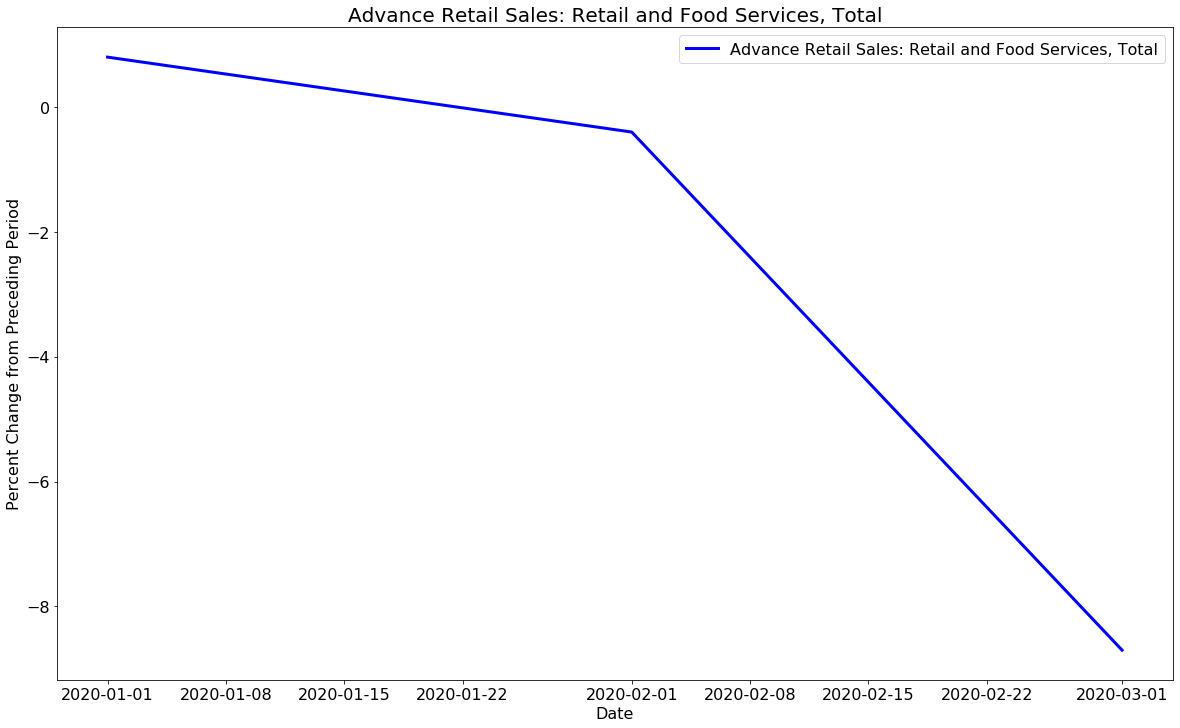

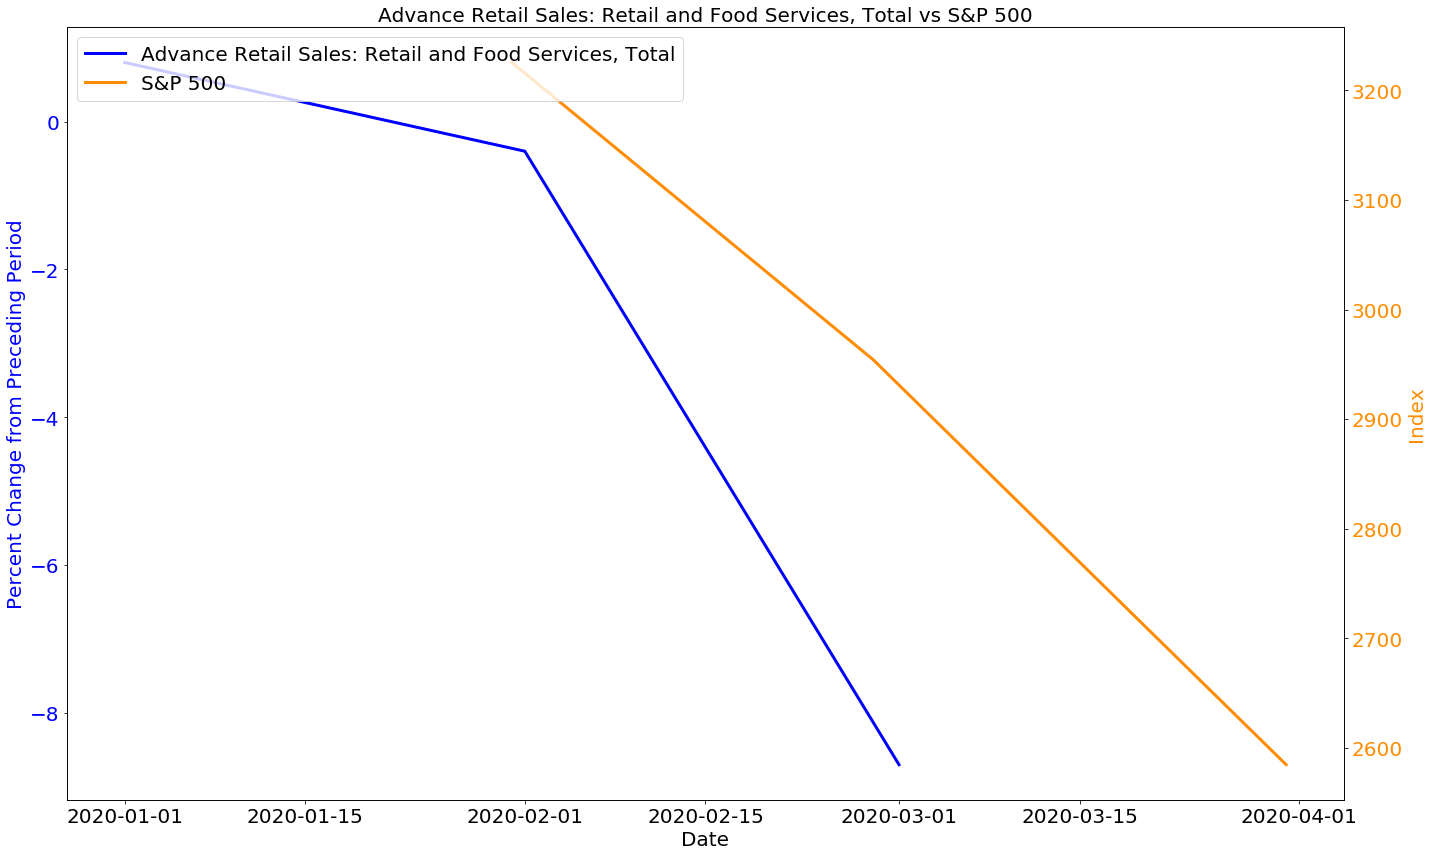

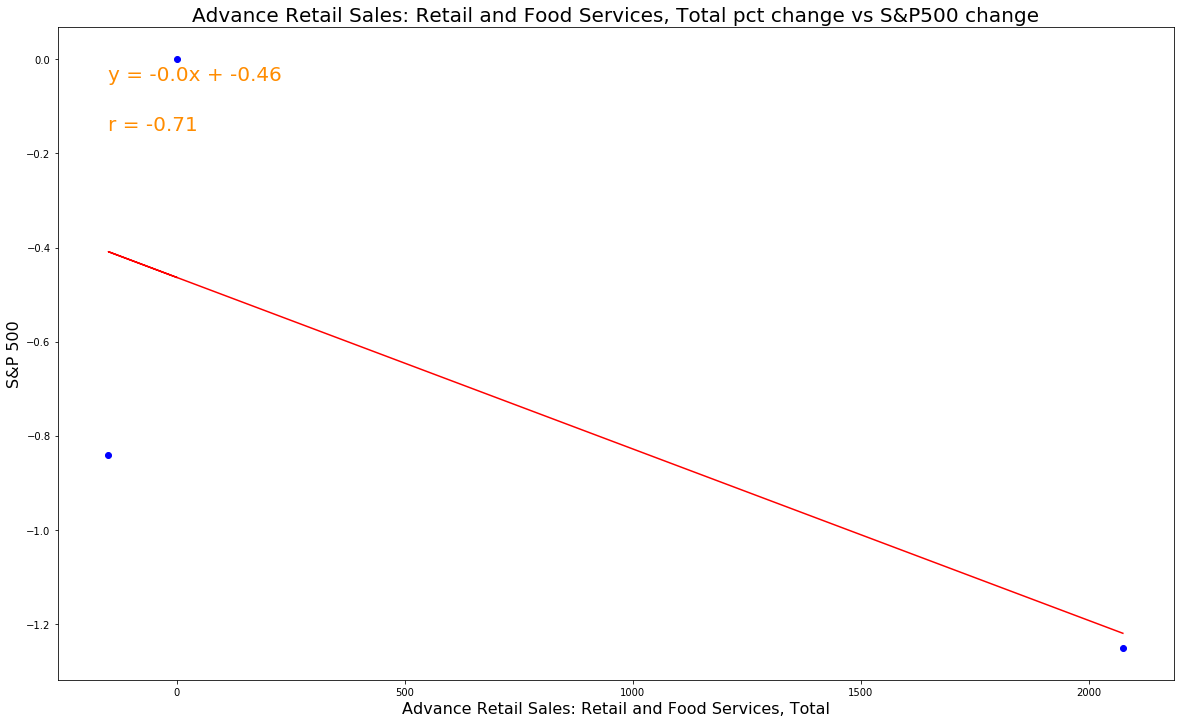

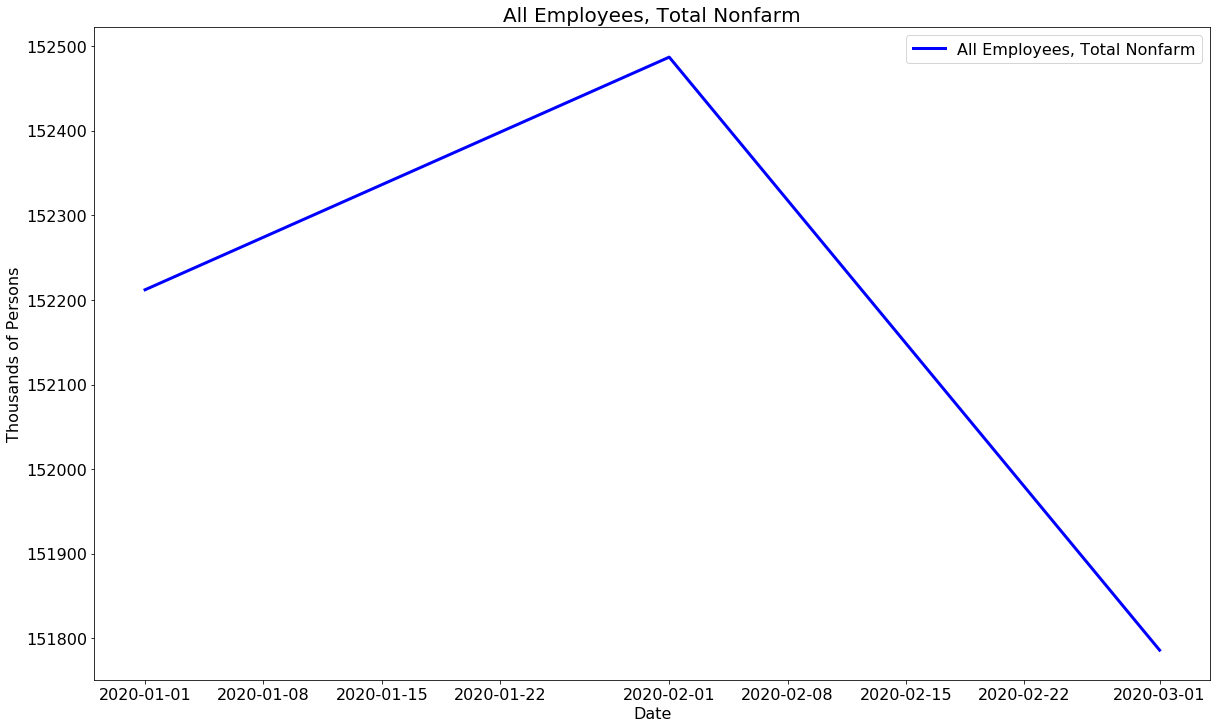

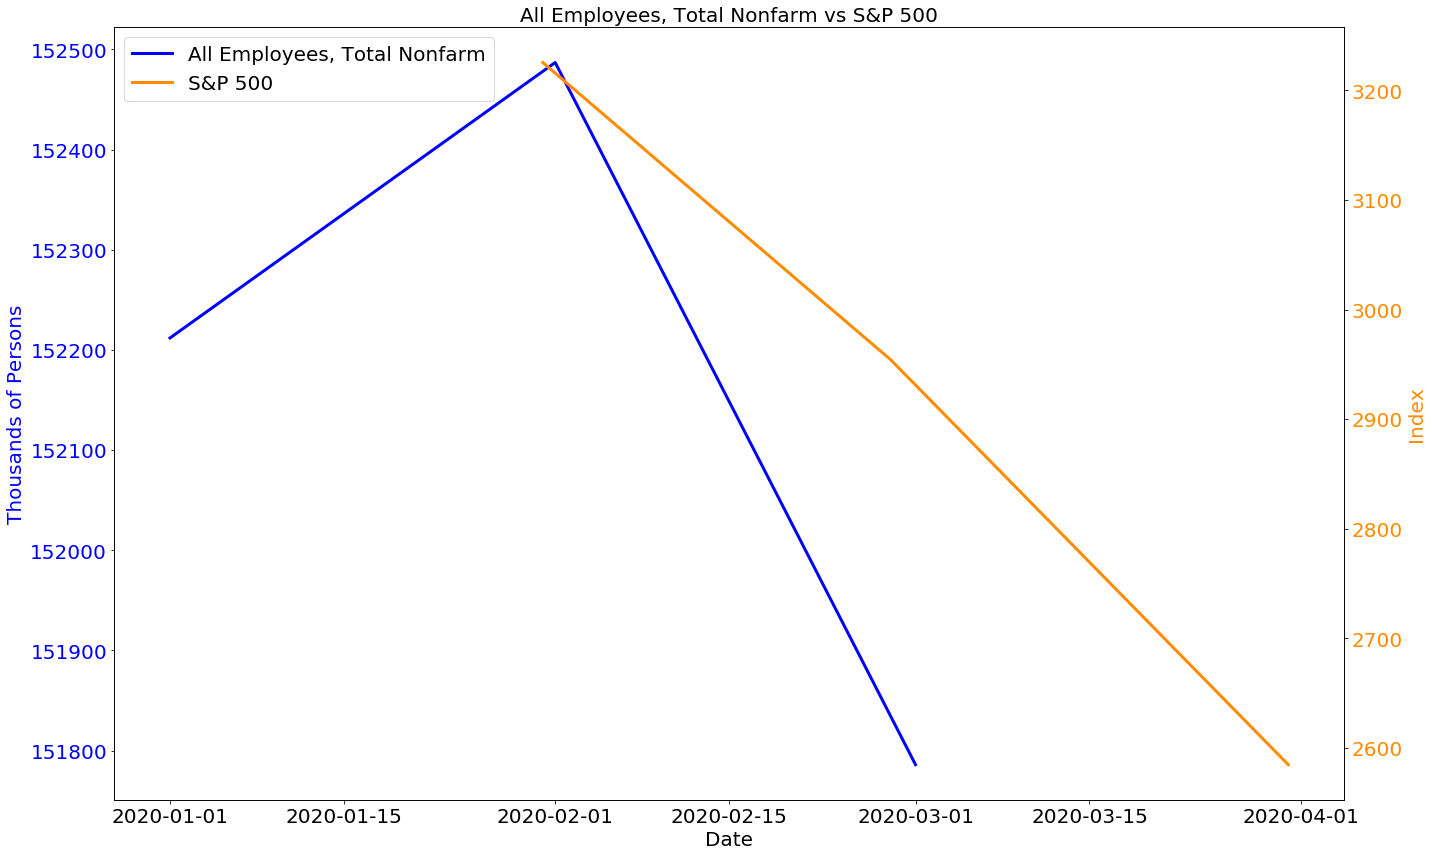

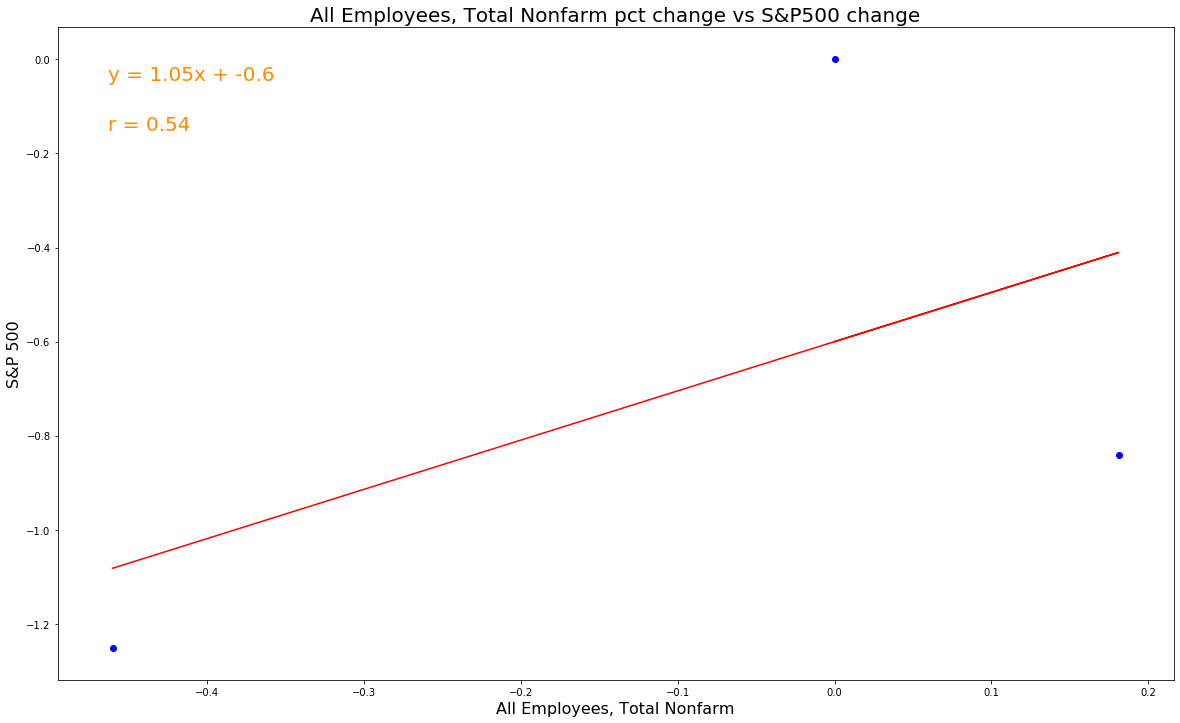

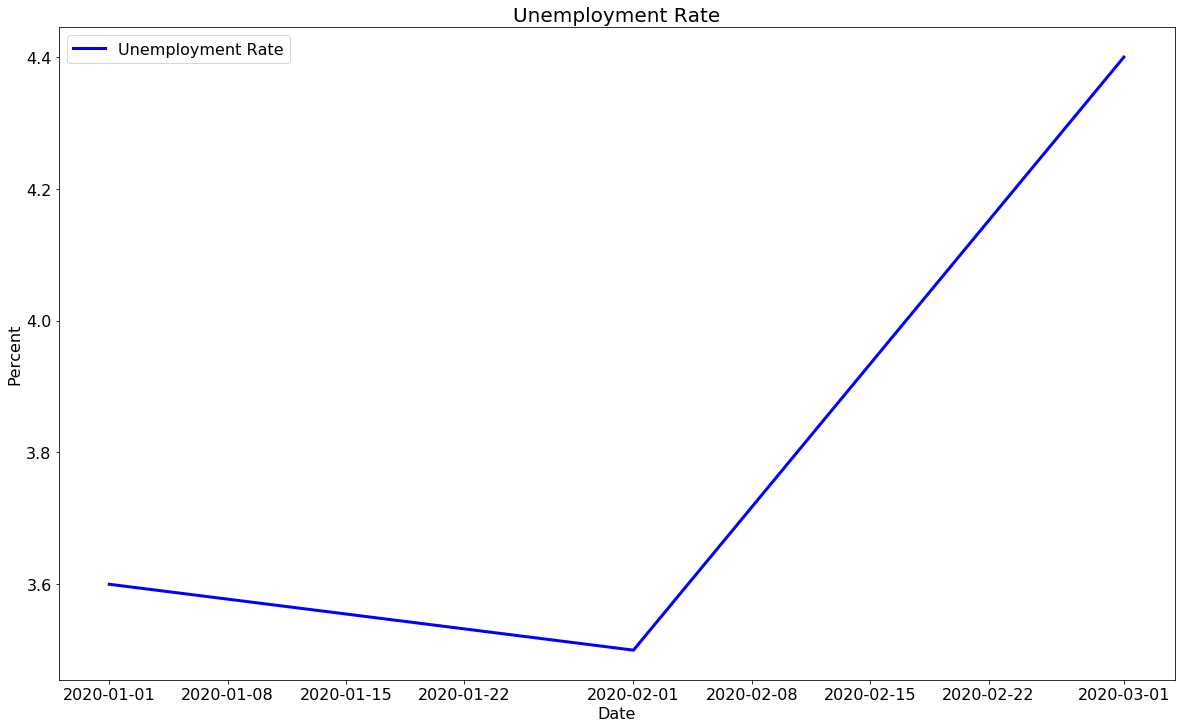

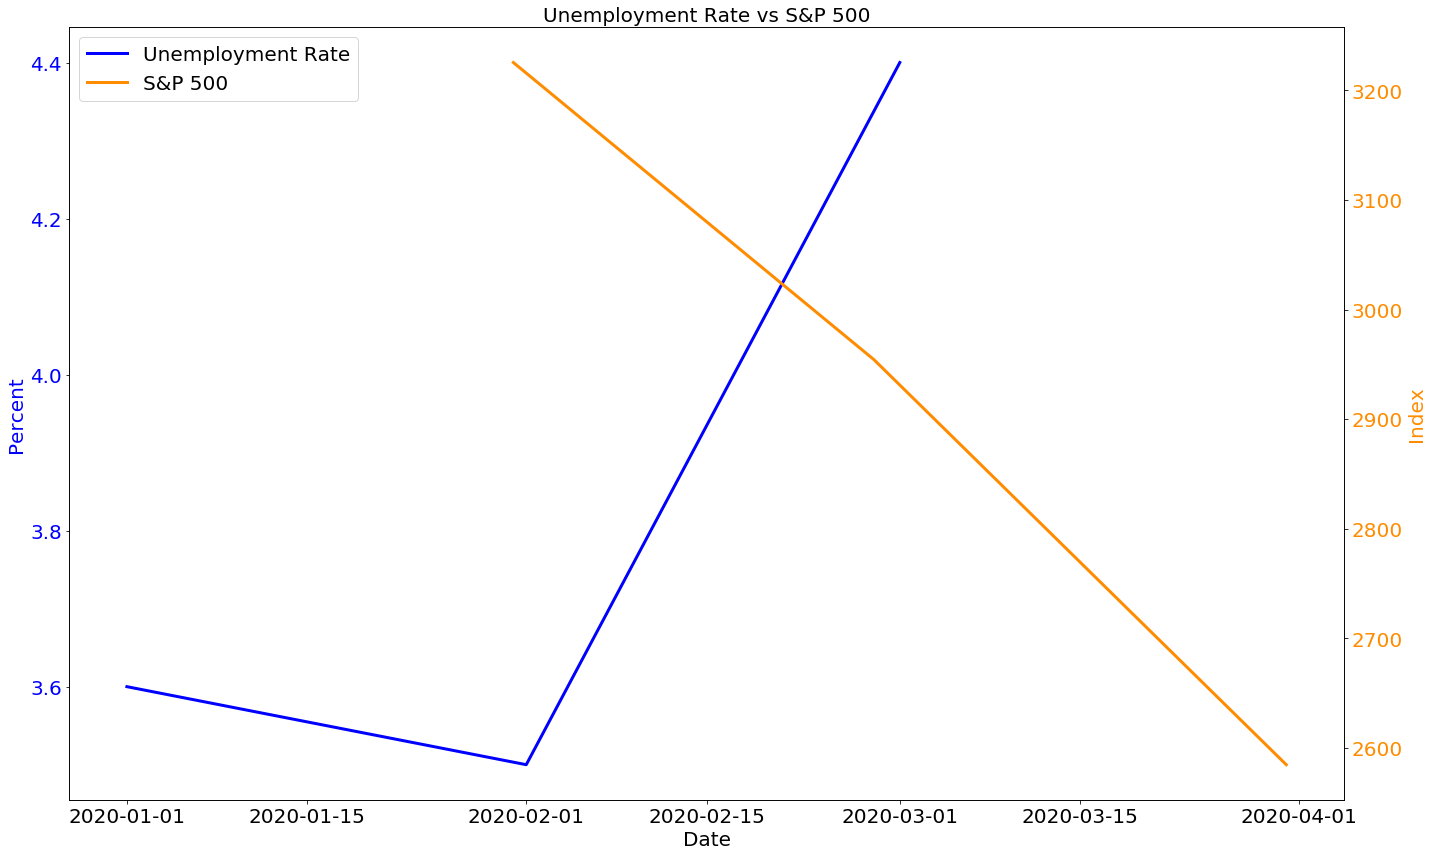

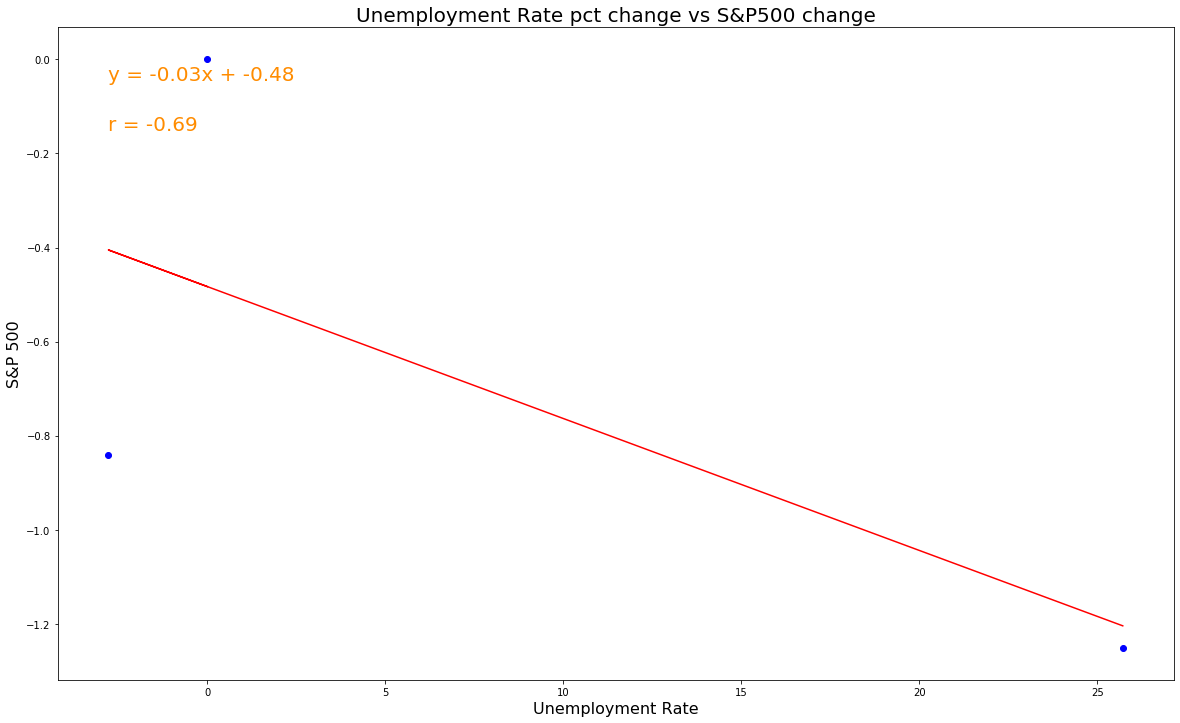

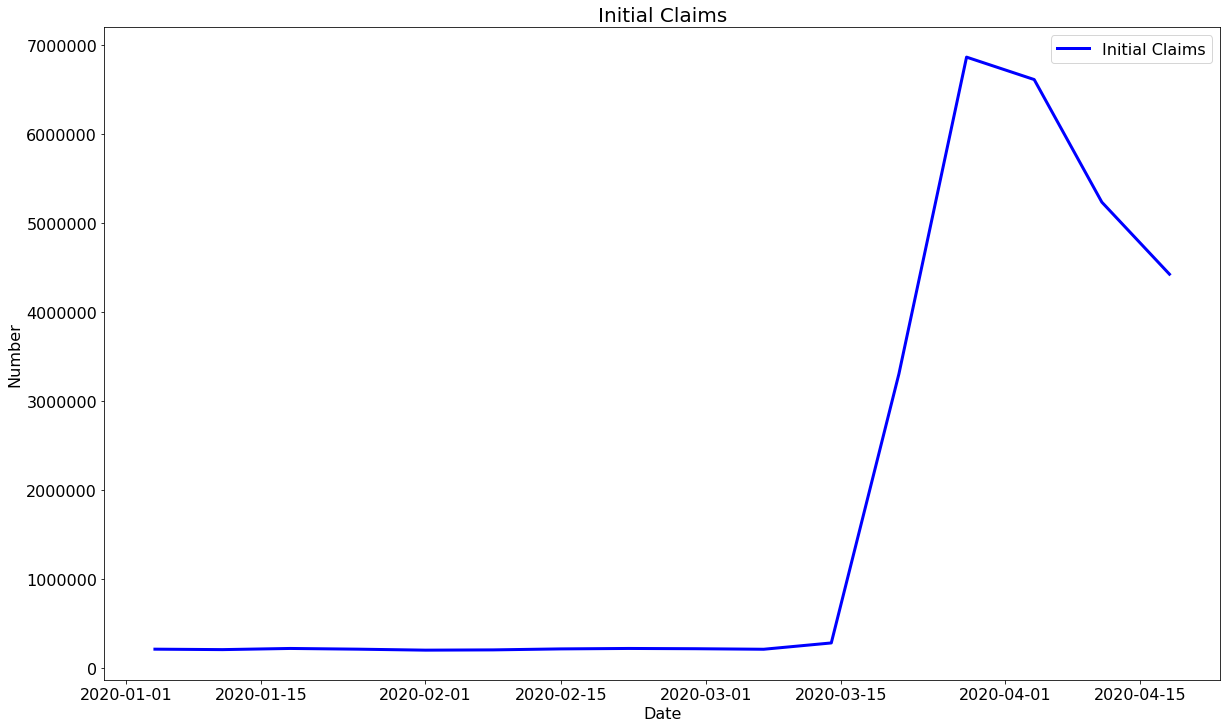

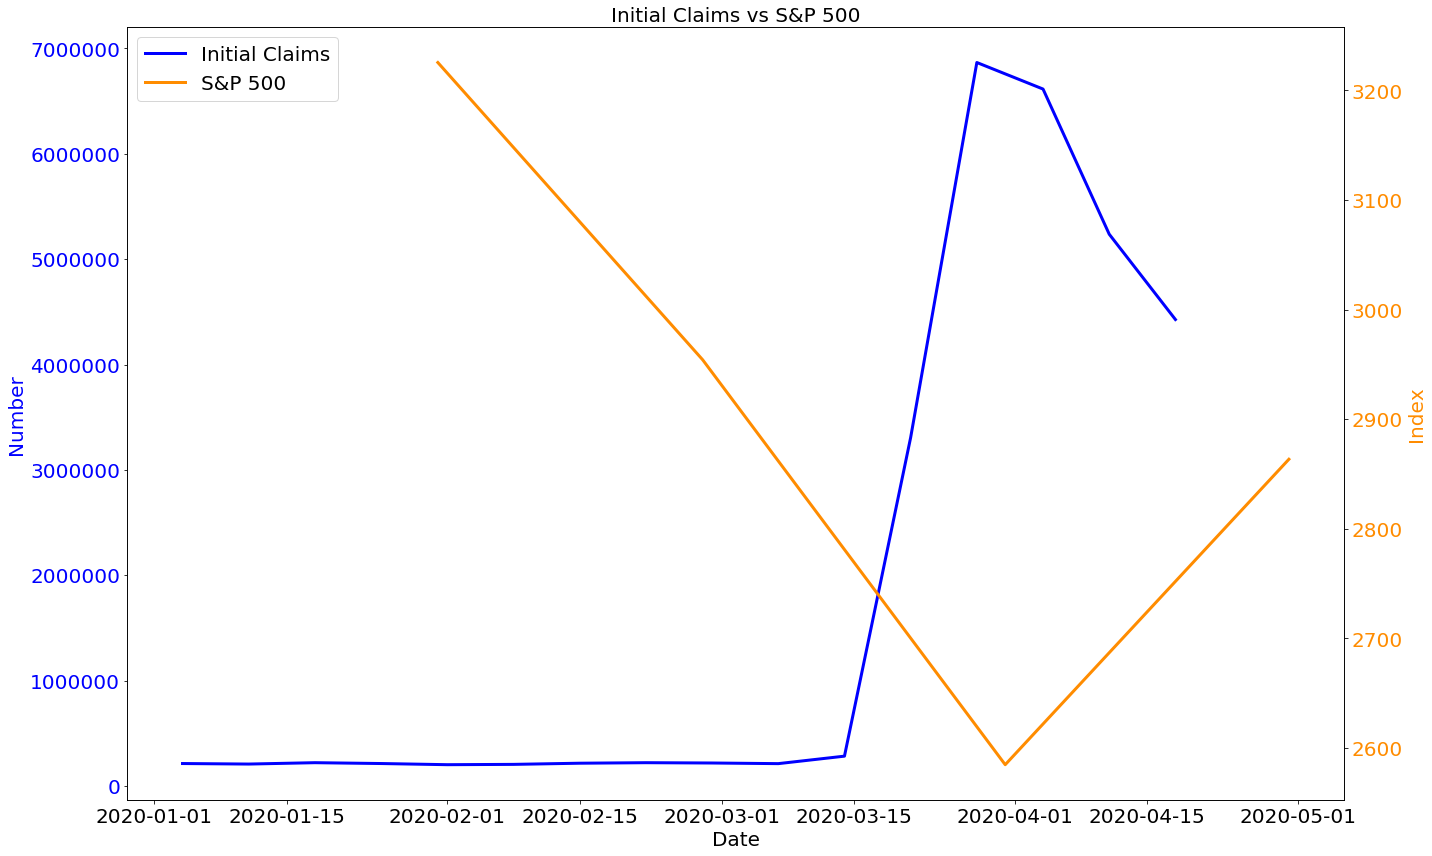

<Figure size 1440x864 with 0 Axes>

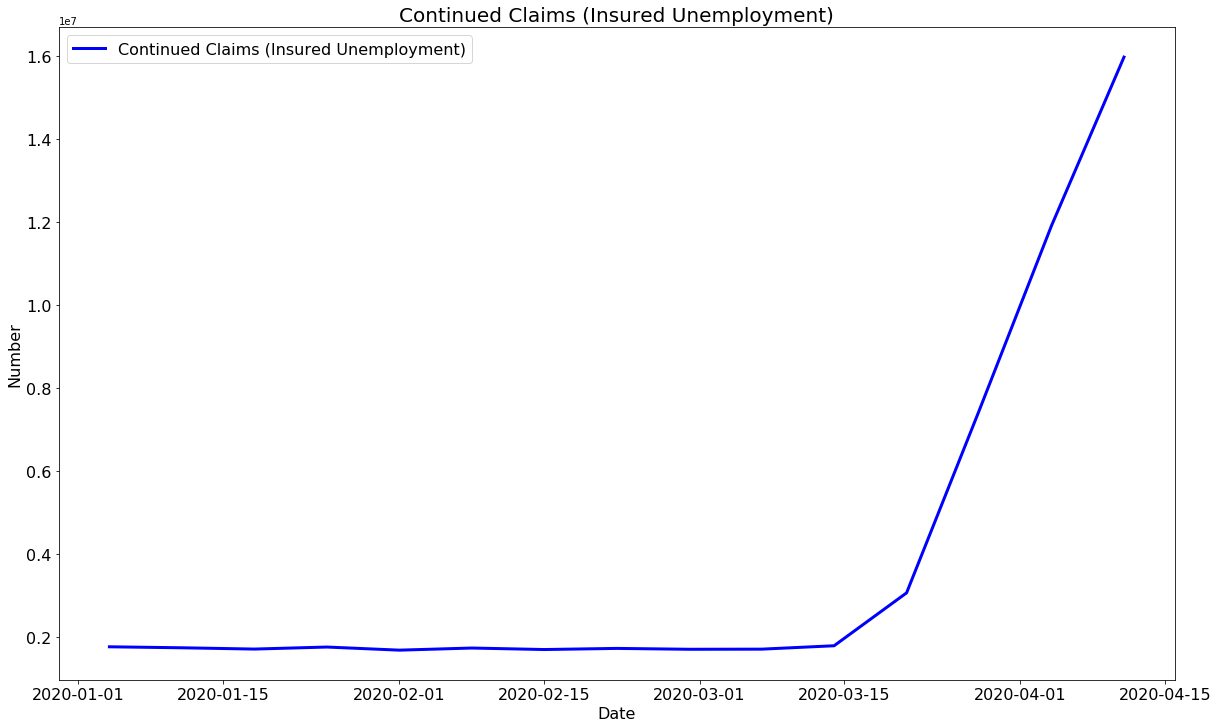

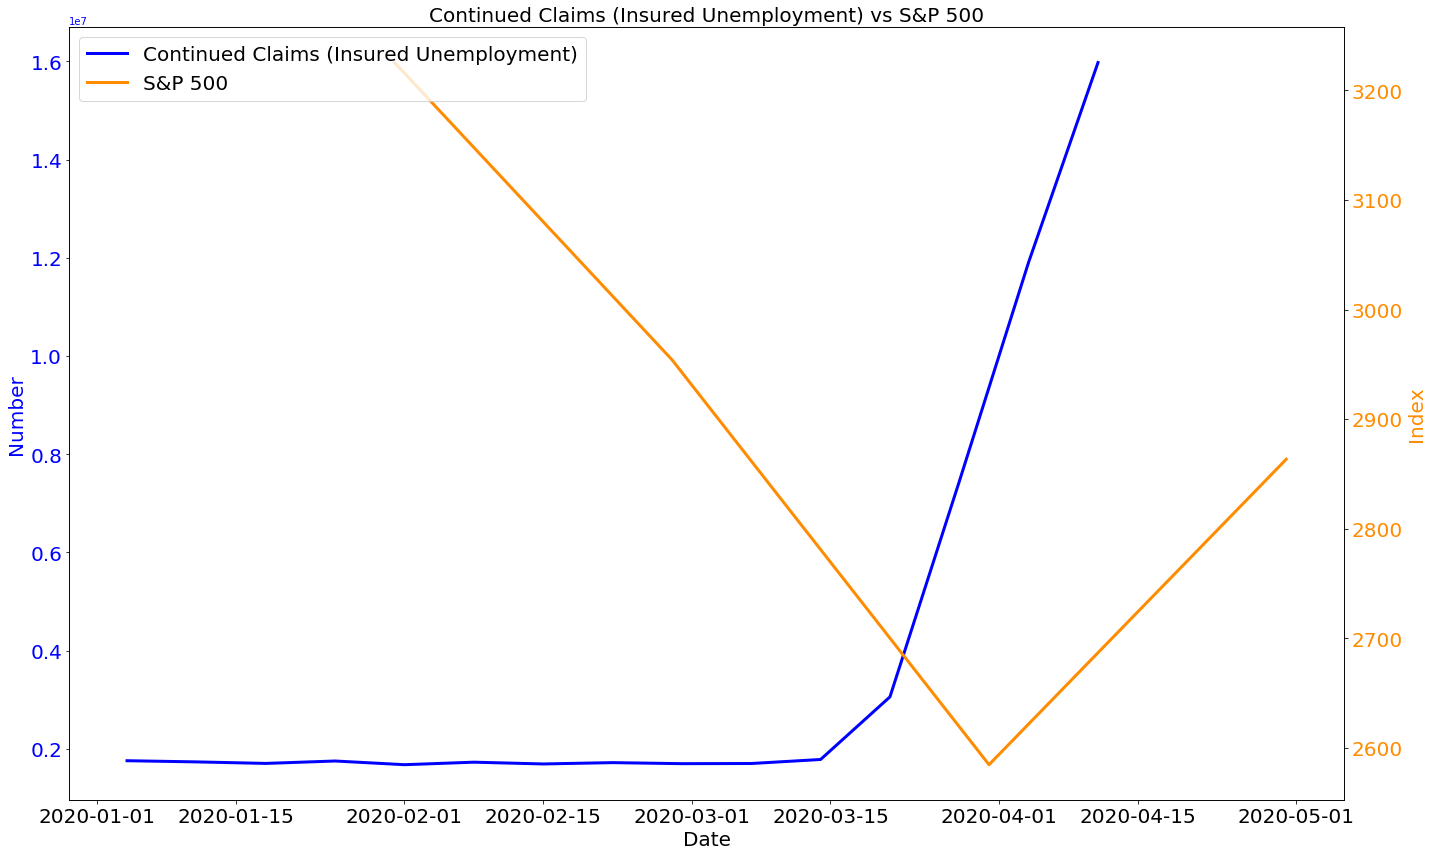

<Figure size 1440x864 with 0 Axes>

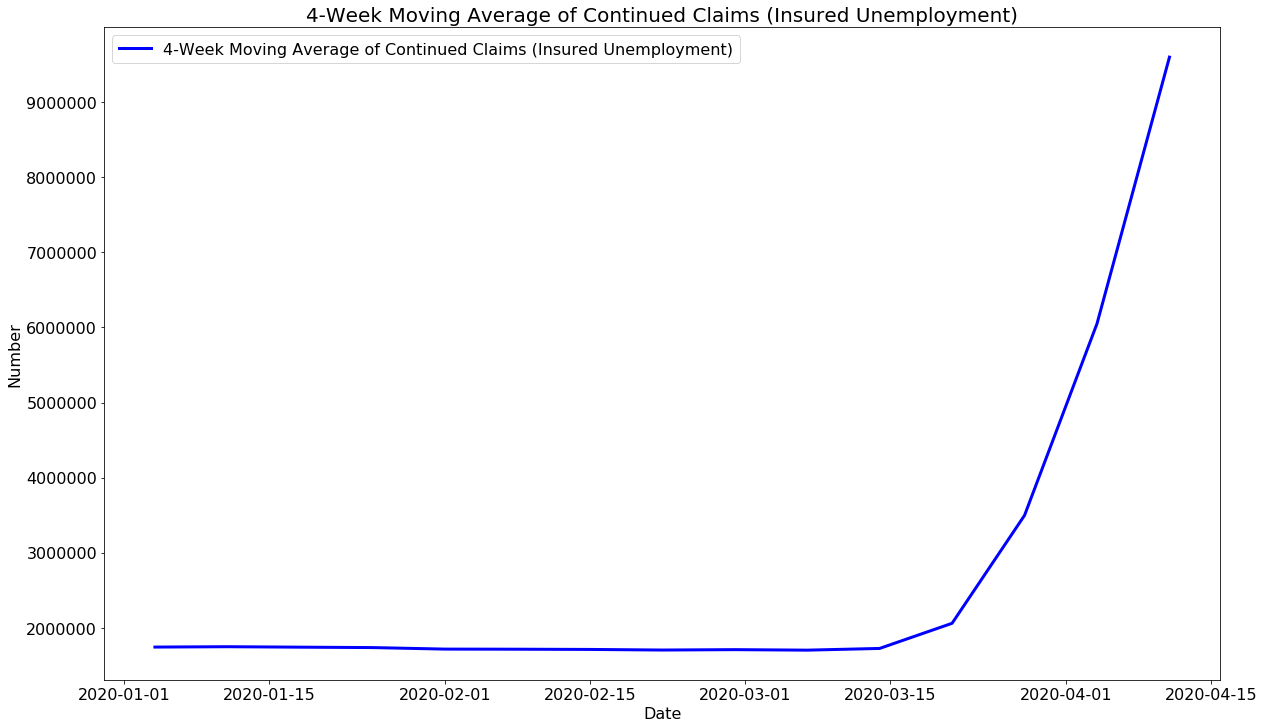

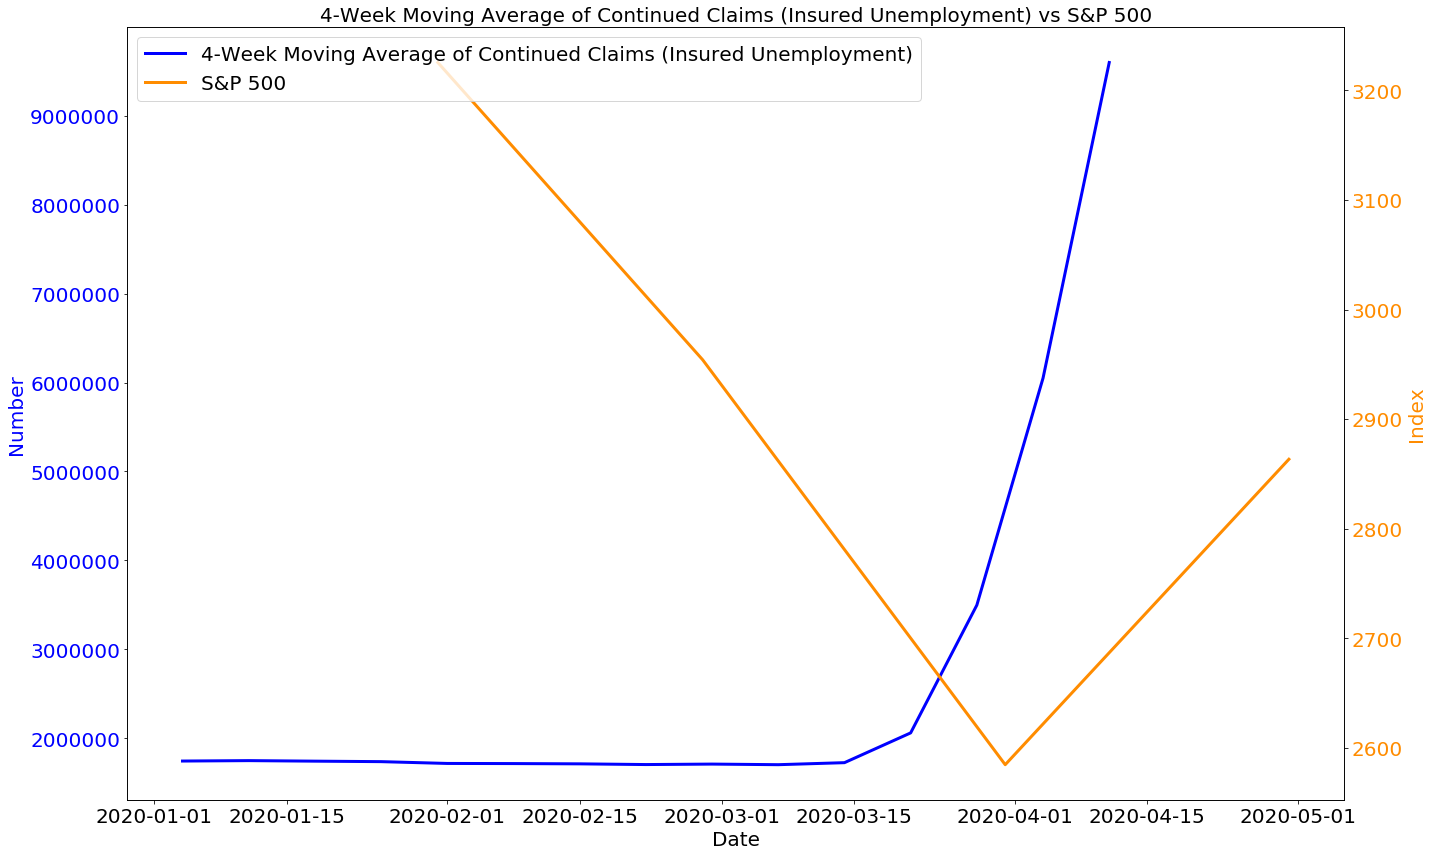

<Figure size 1440x864 with 0 Axes>

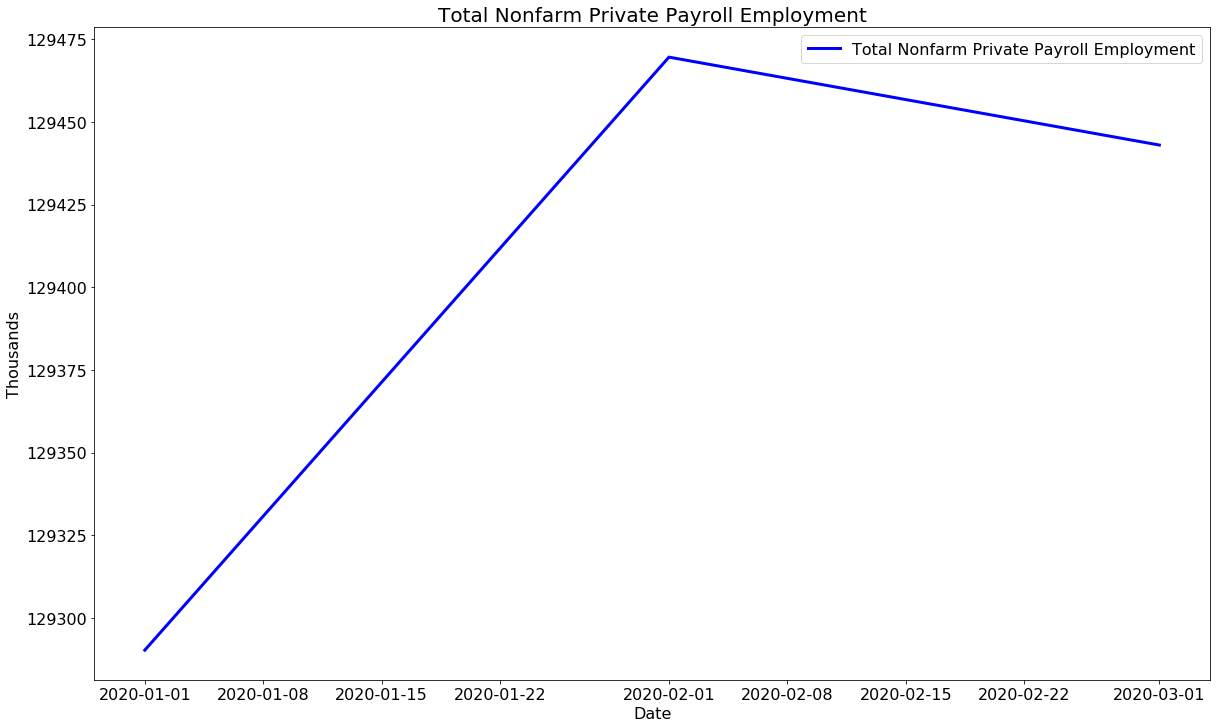

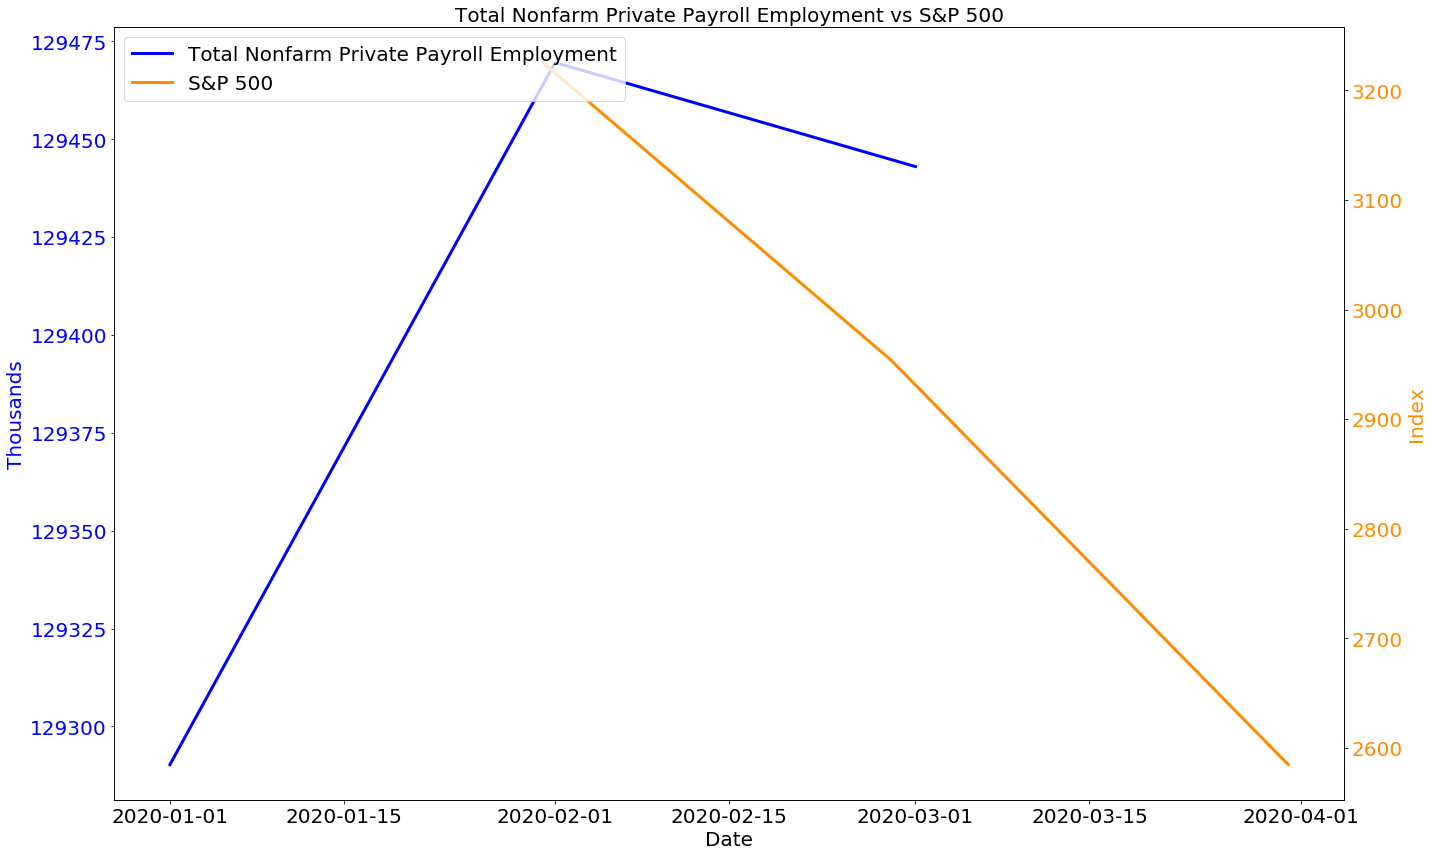

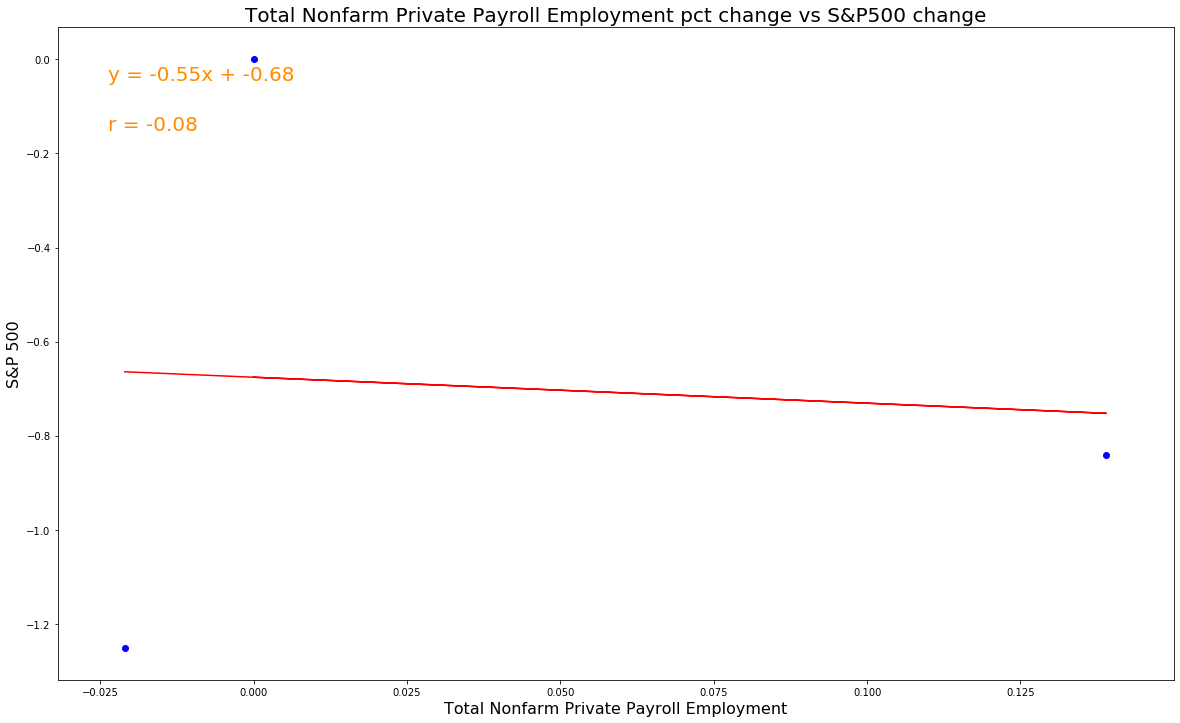

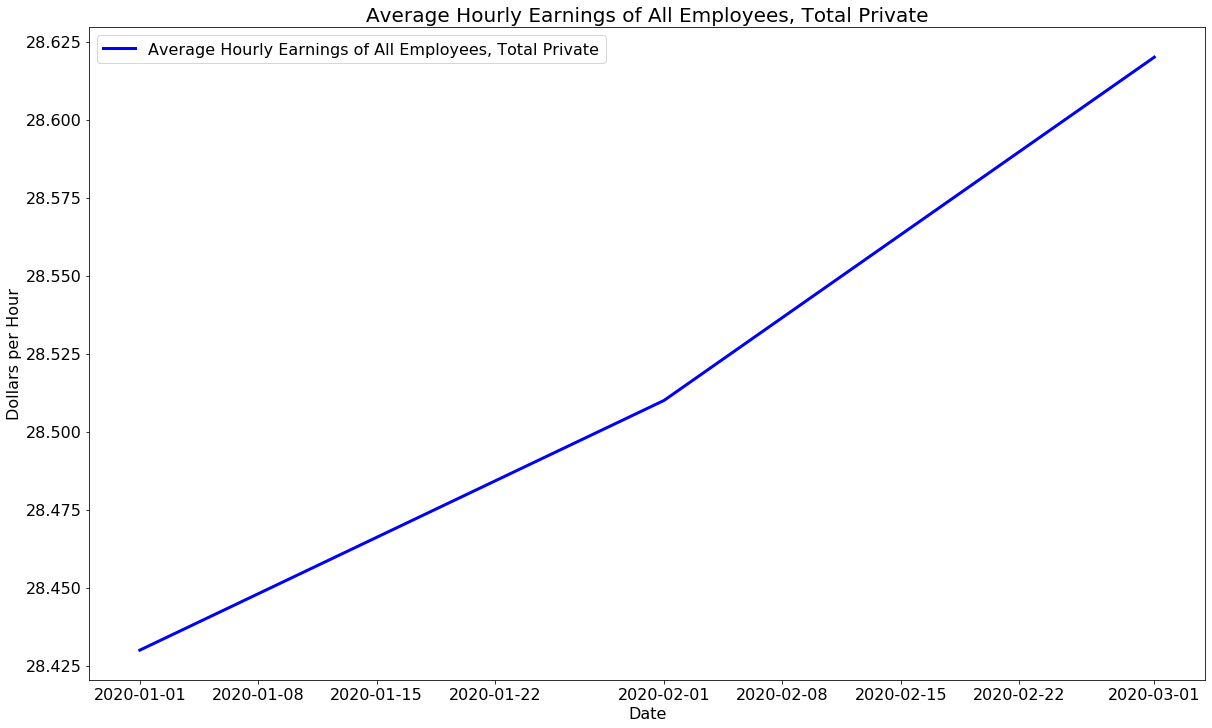

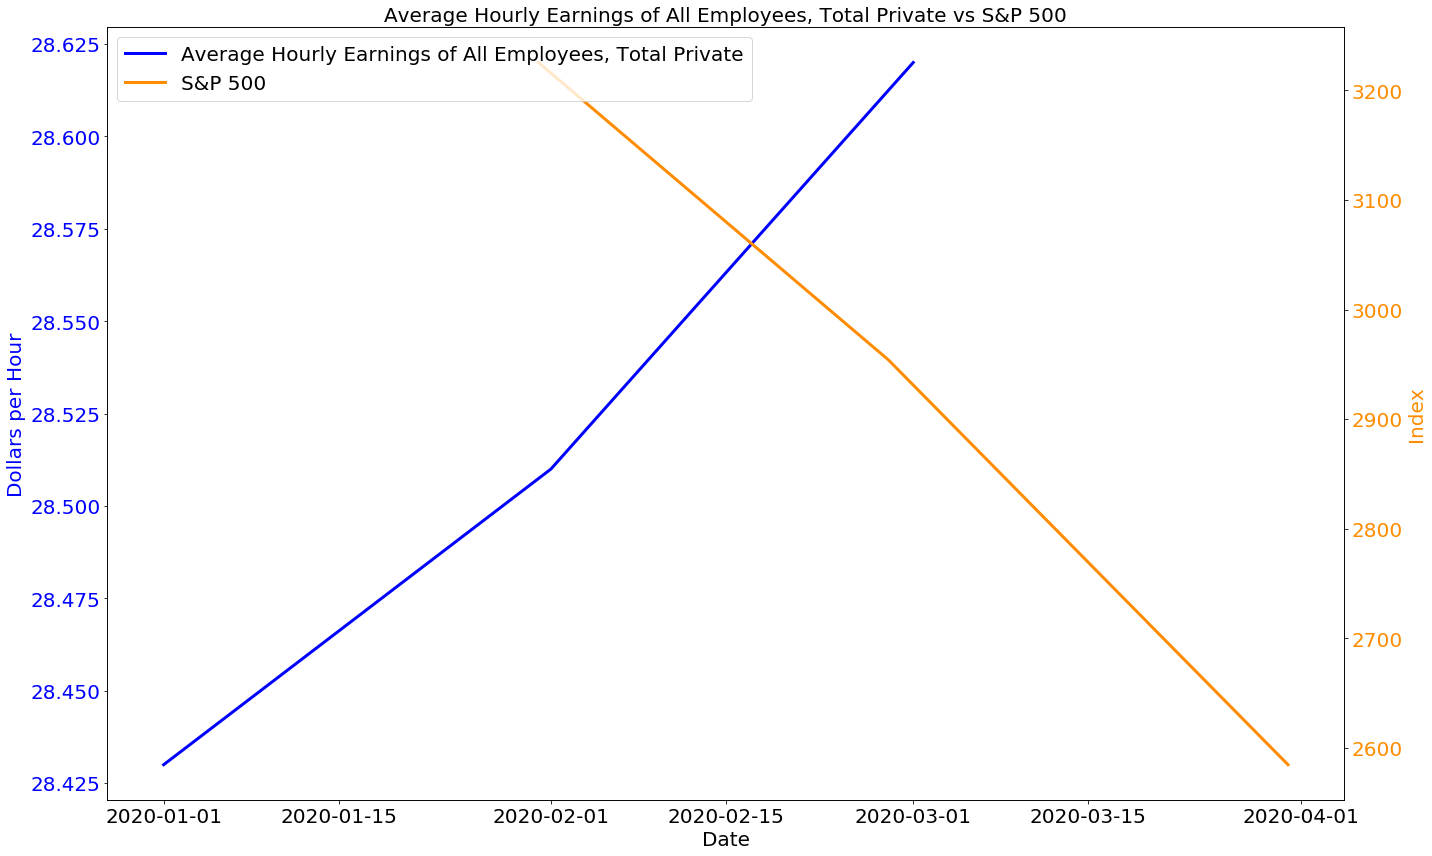

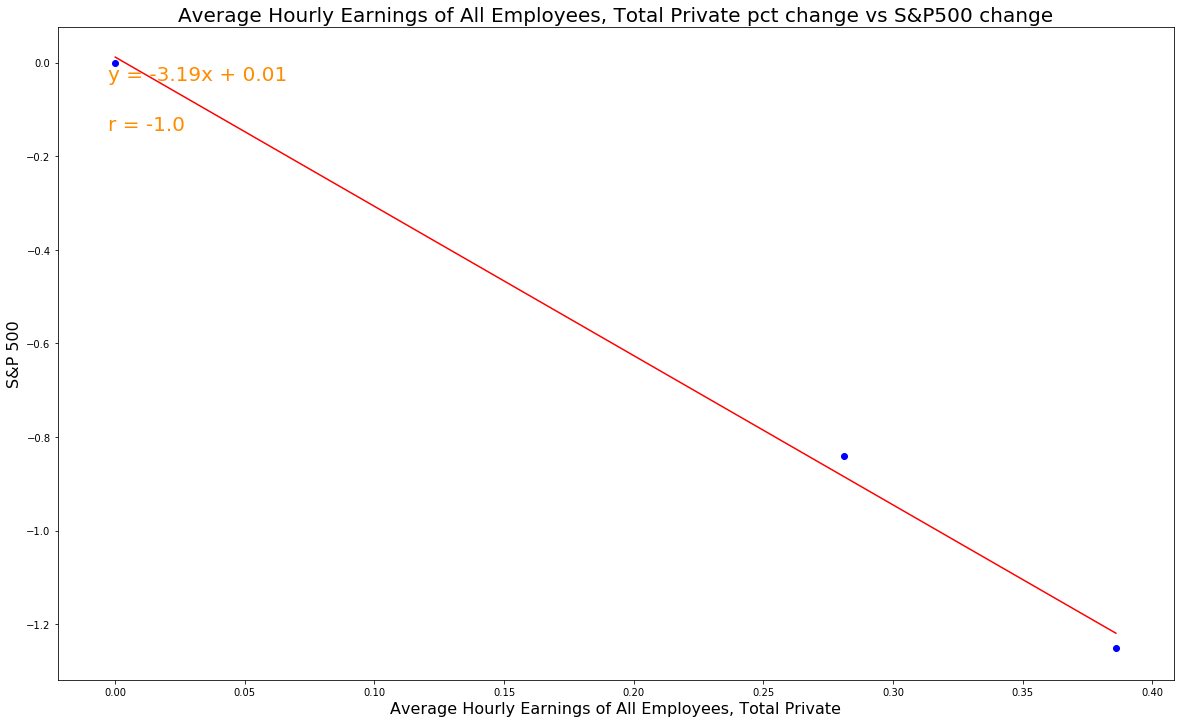

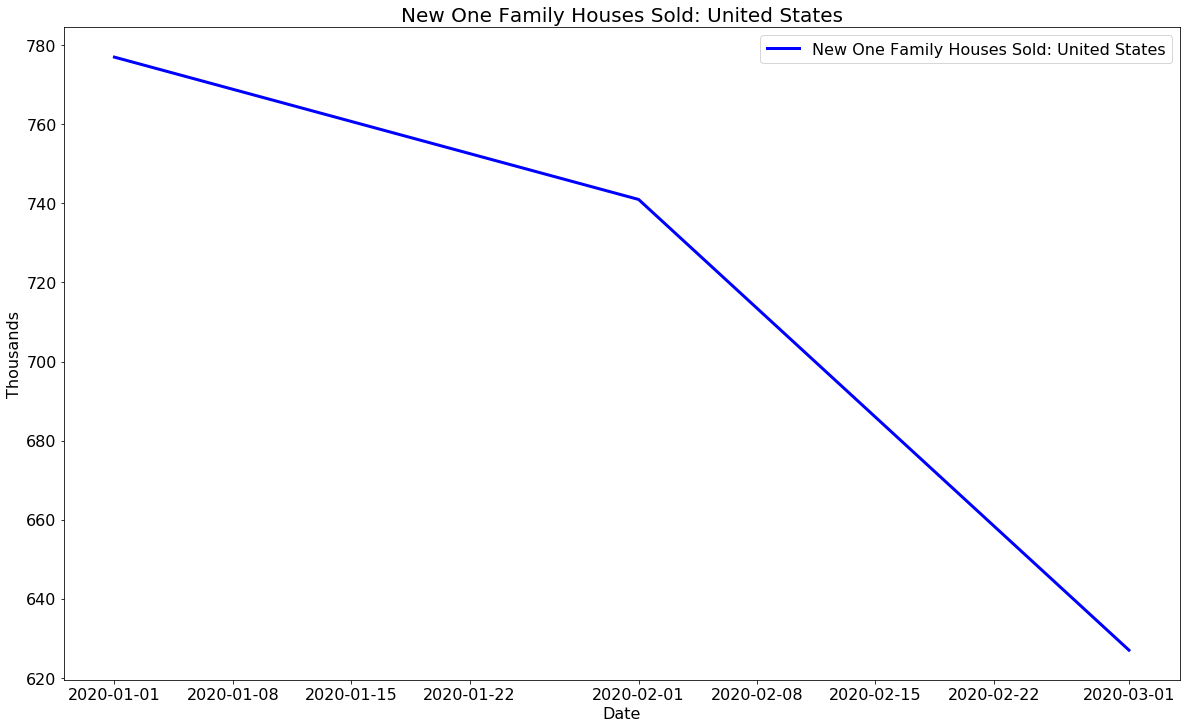

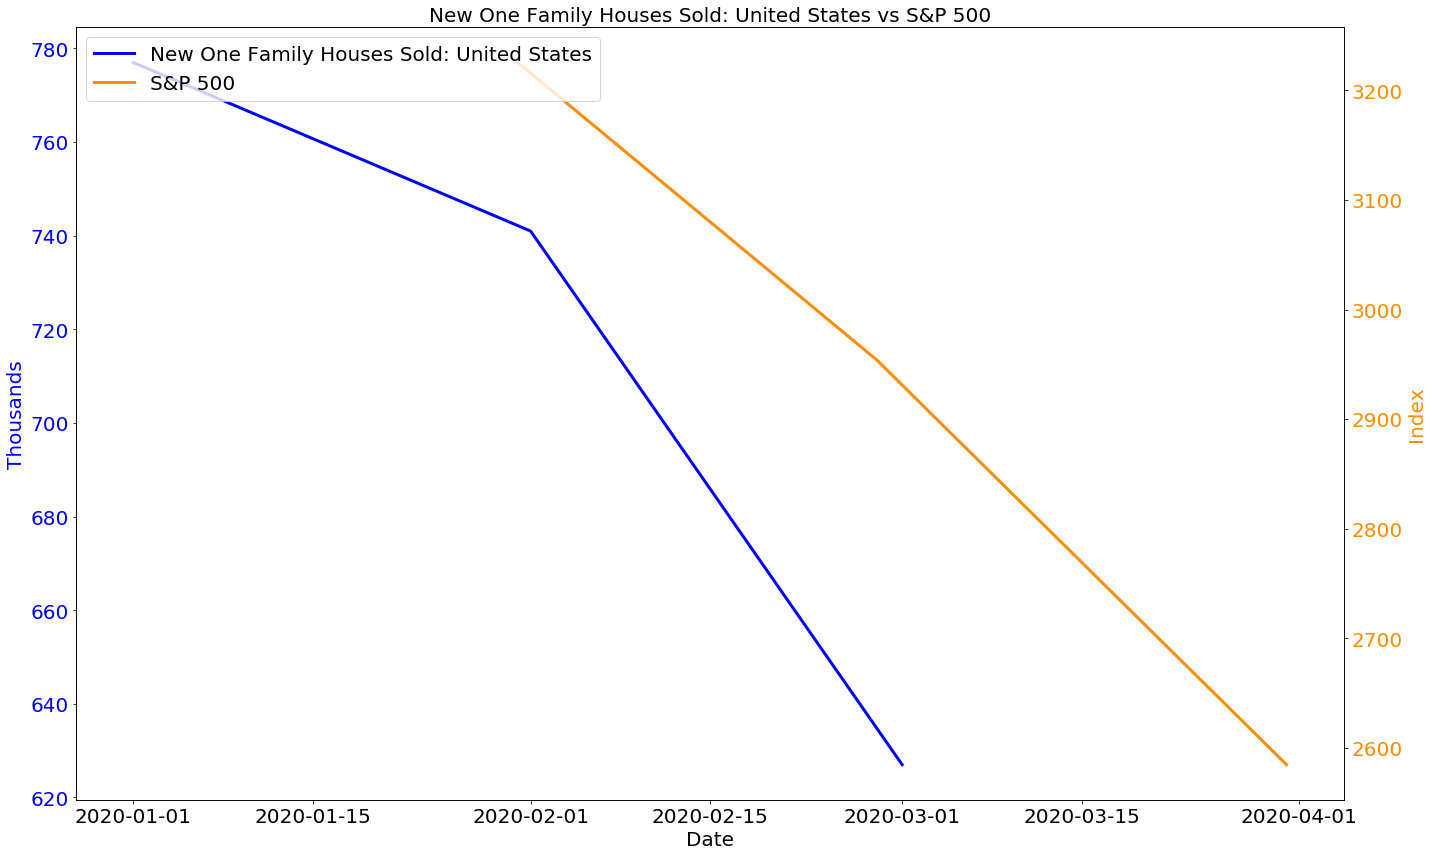

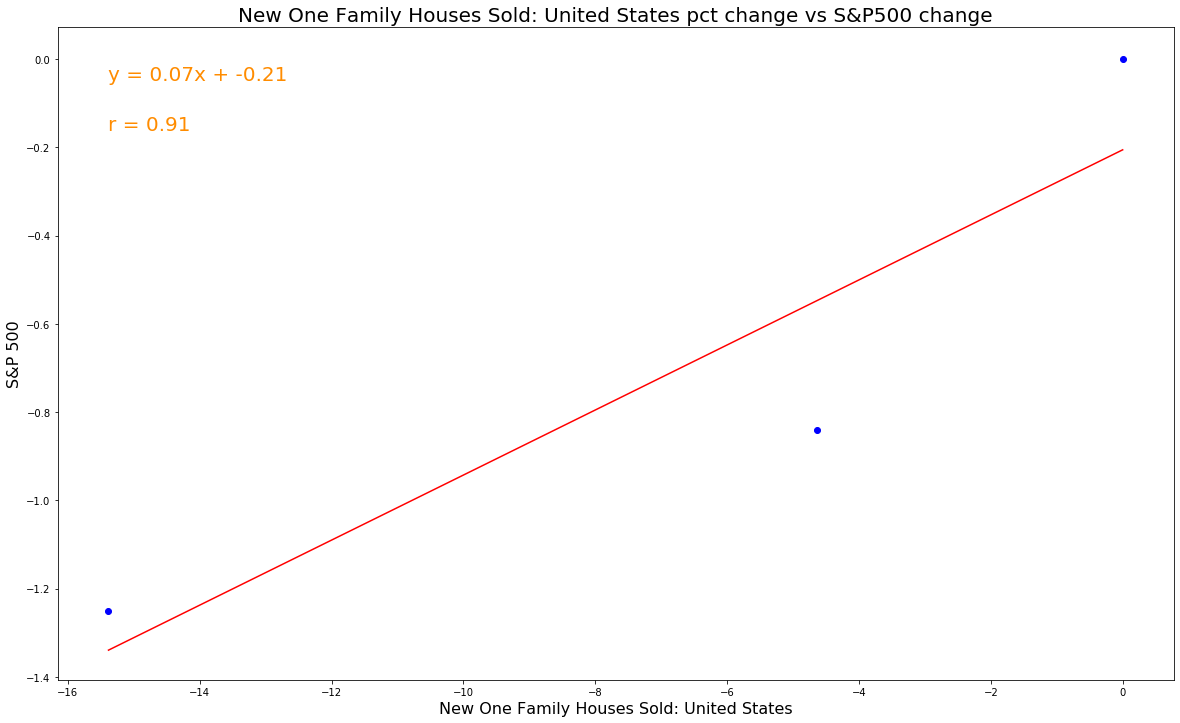

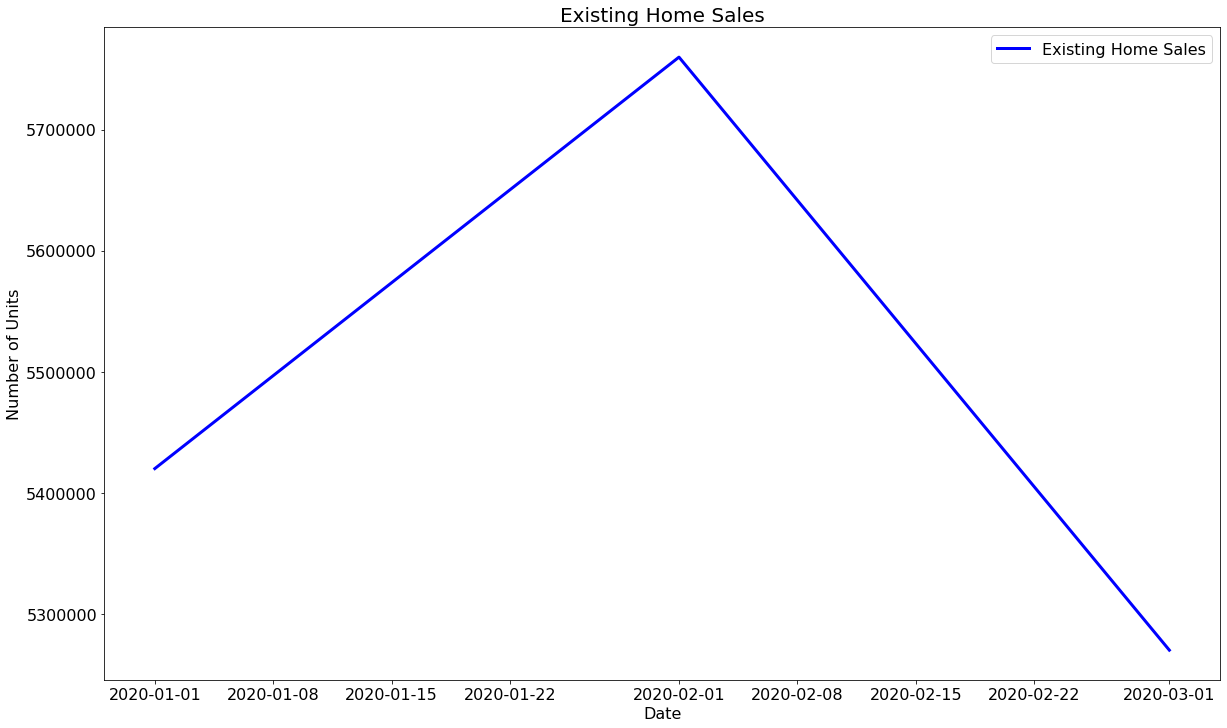

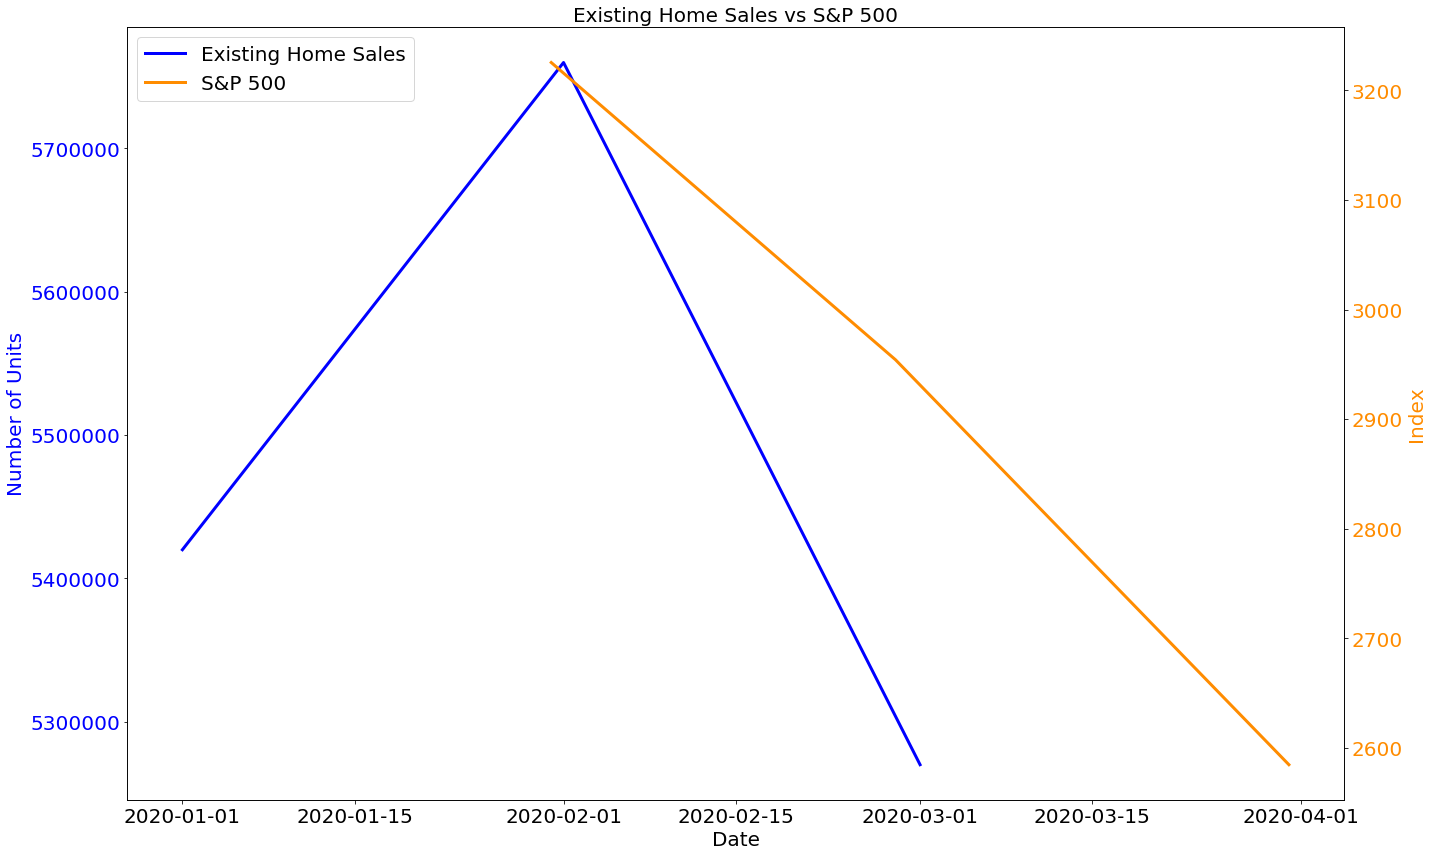

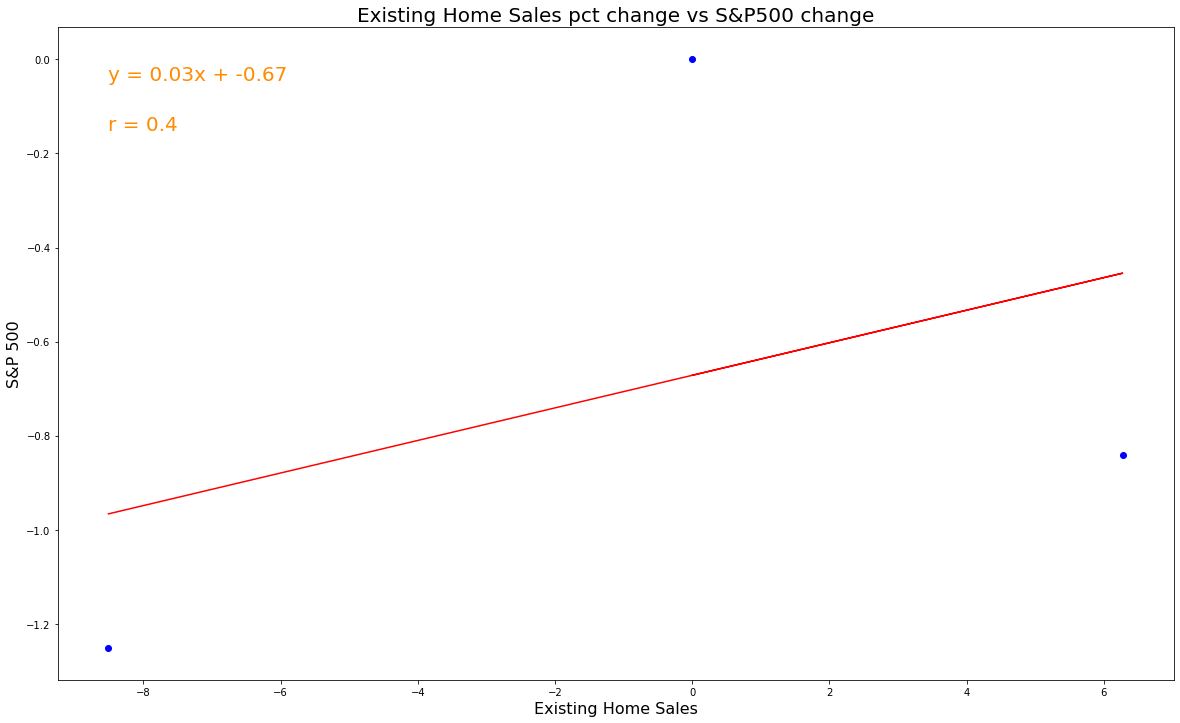

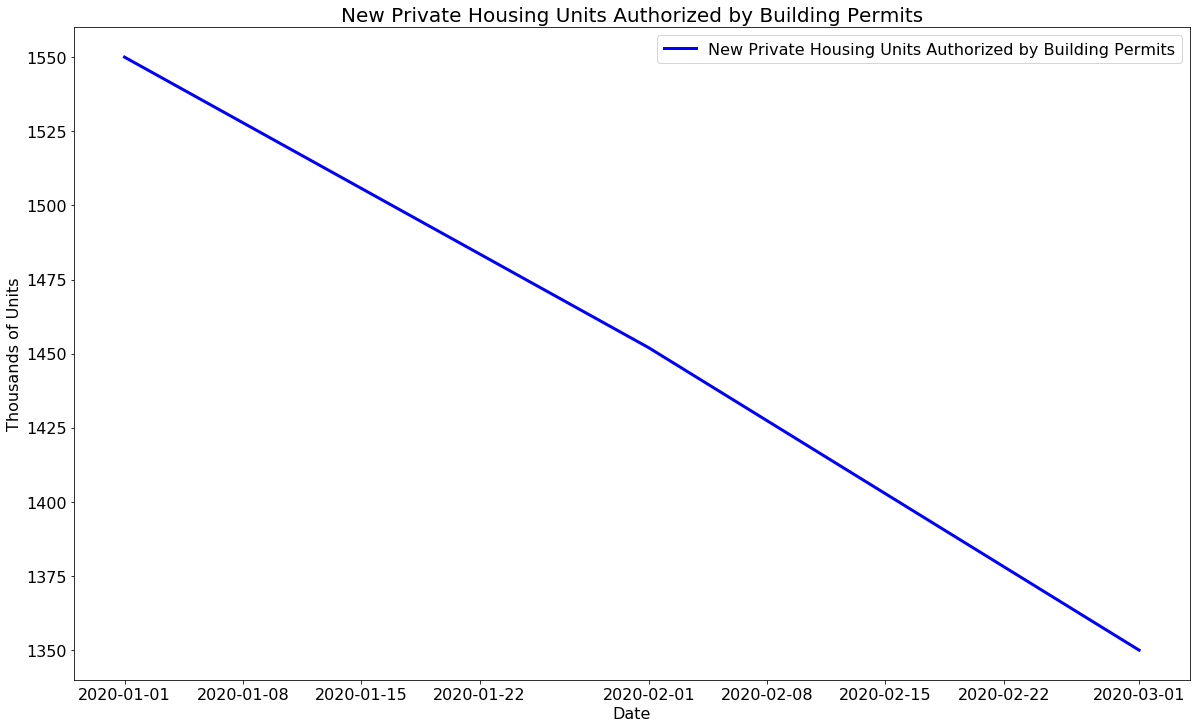

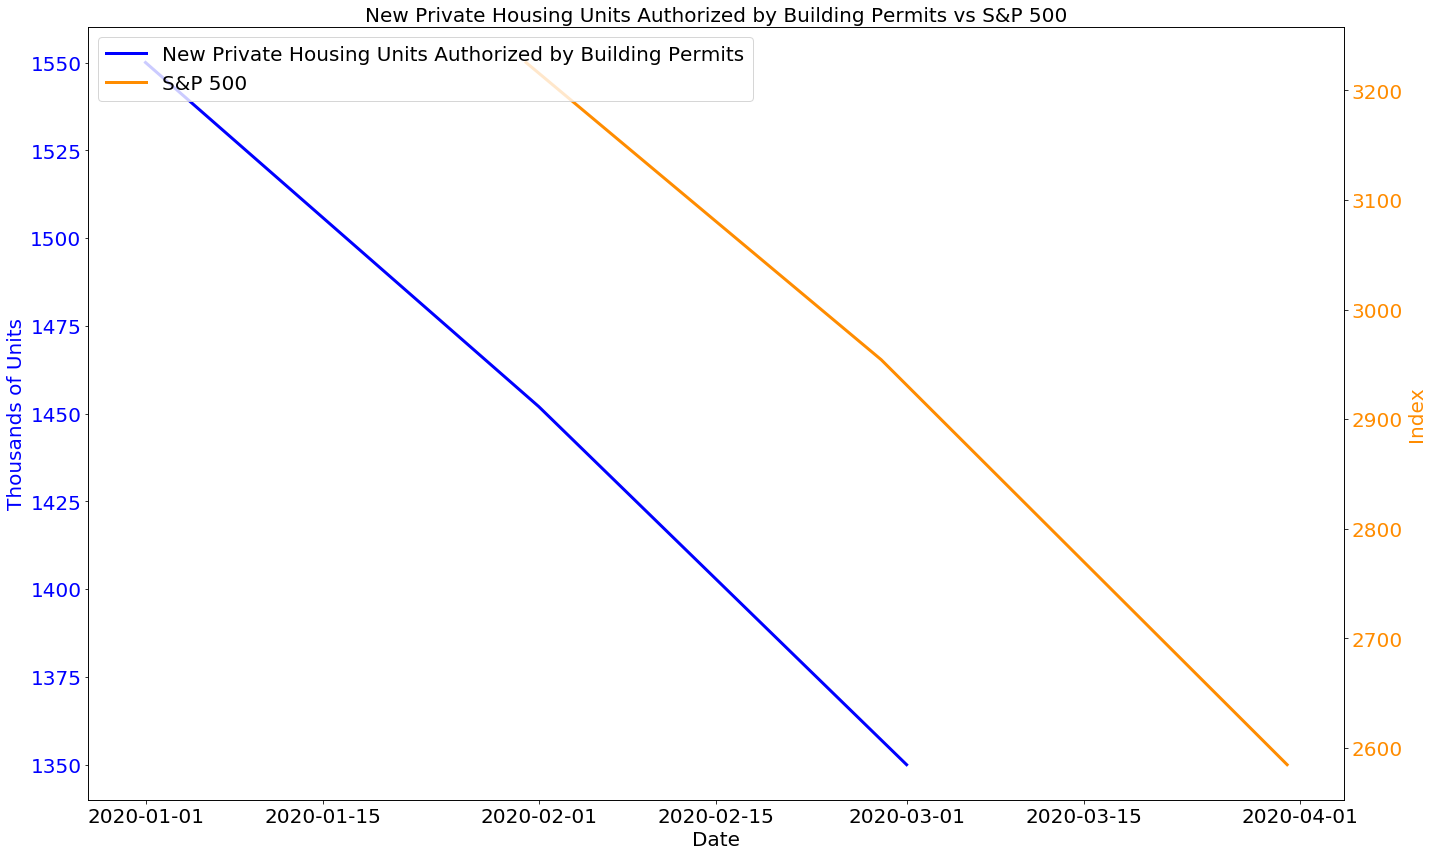

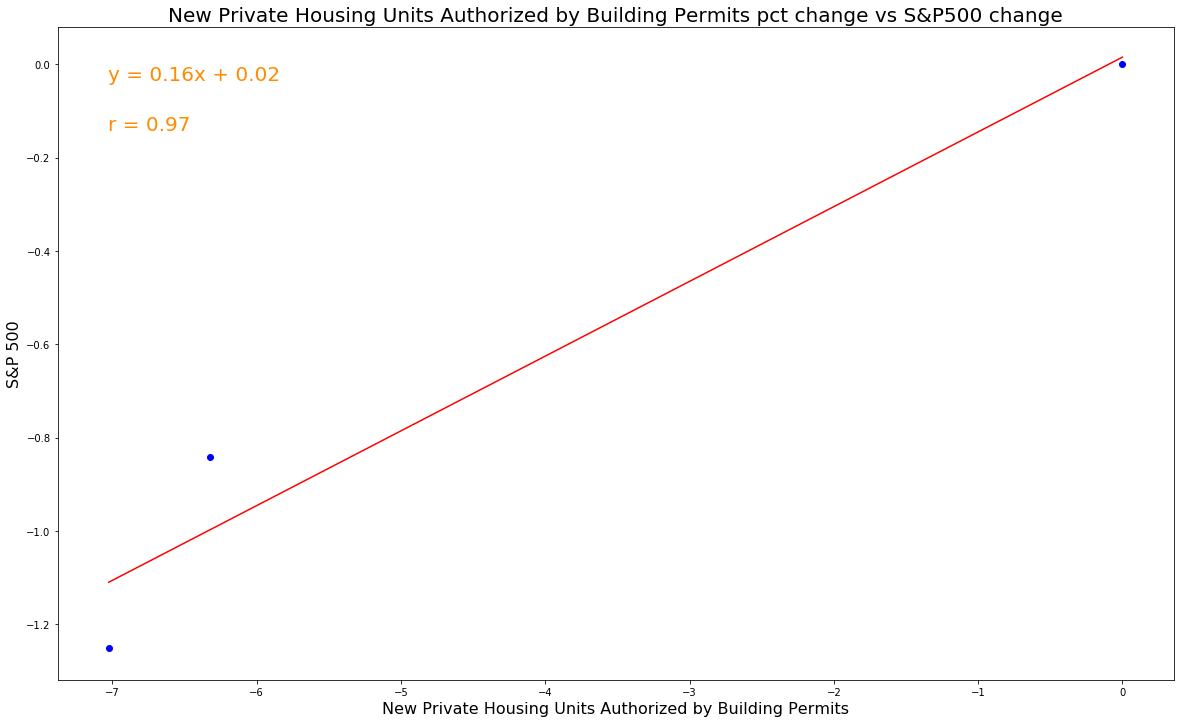

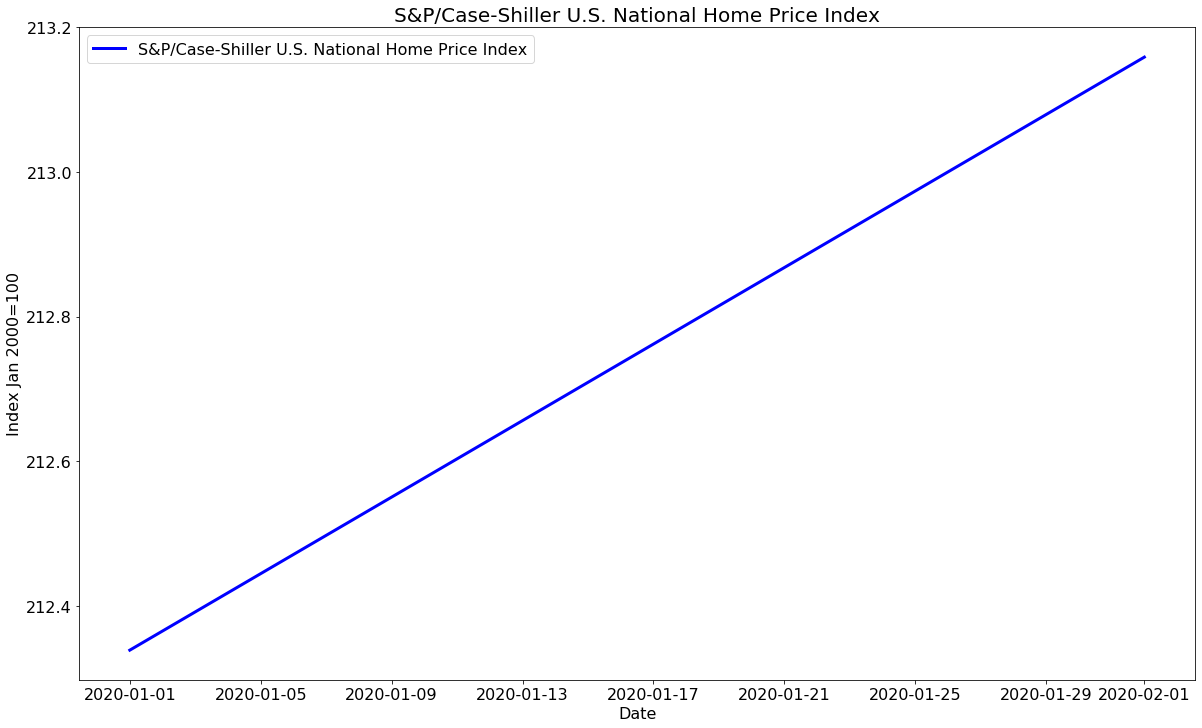

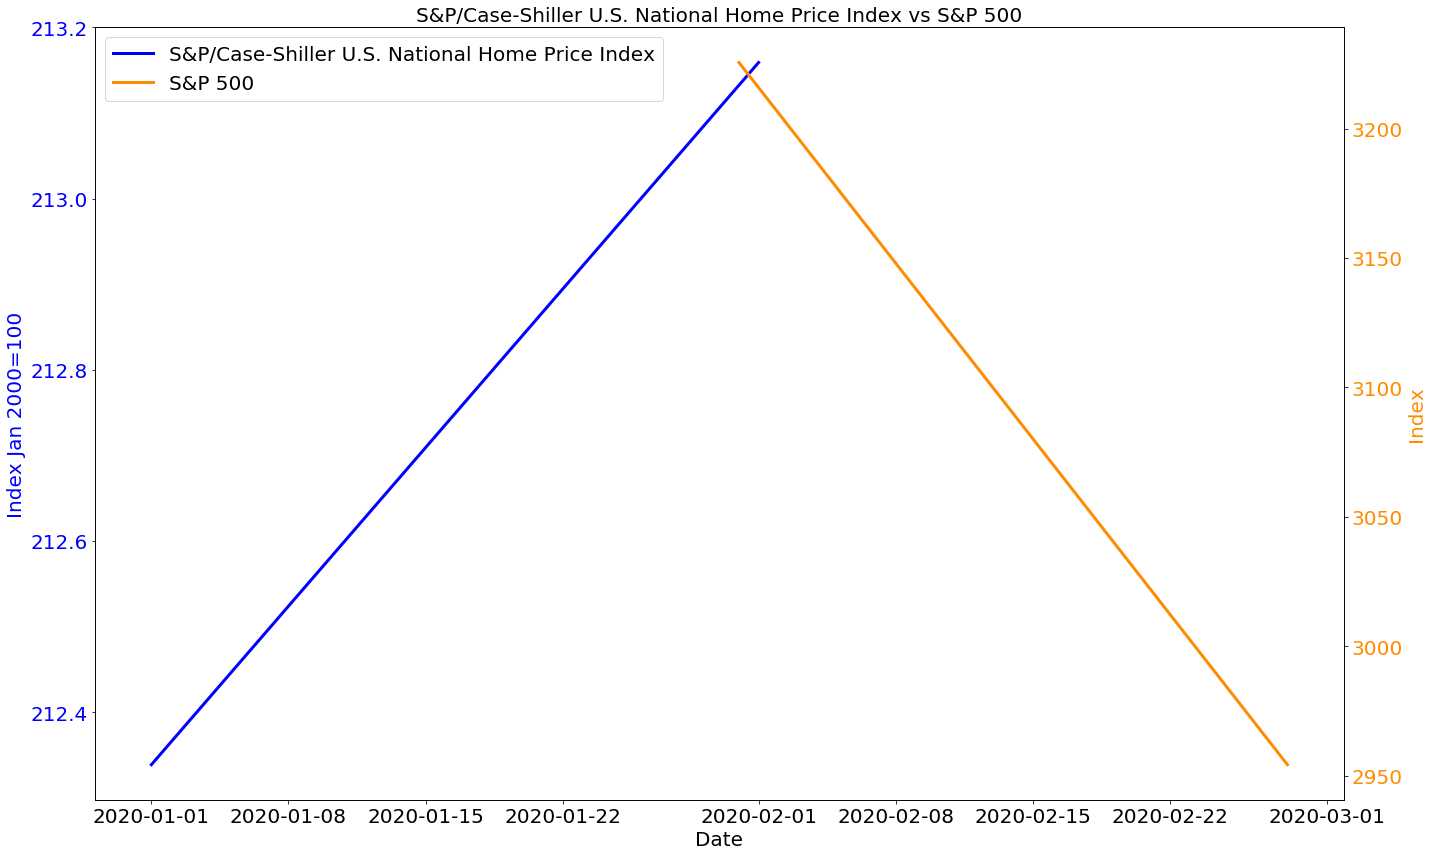

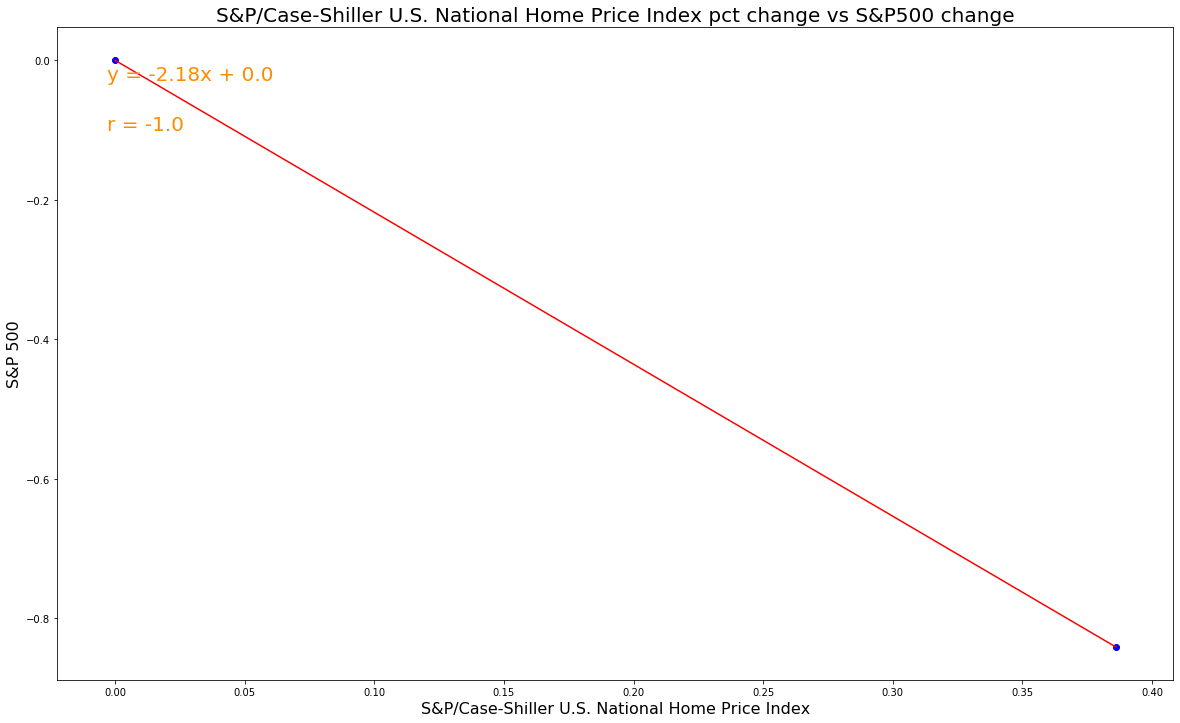

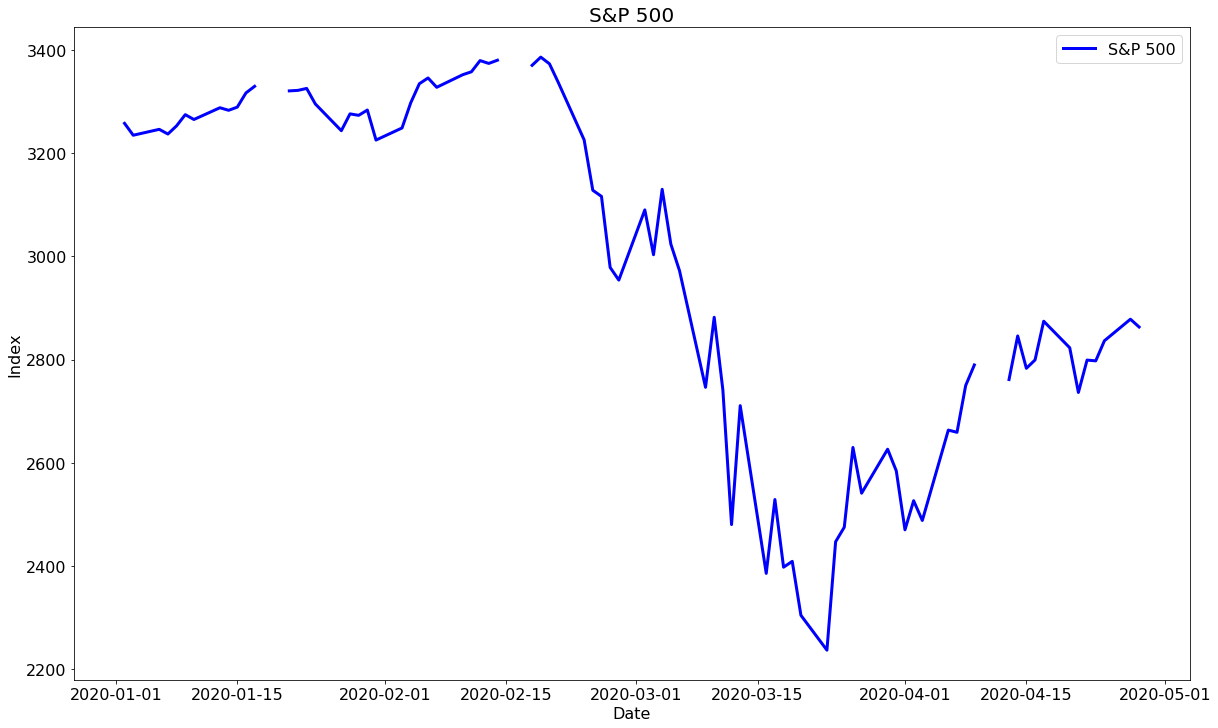

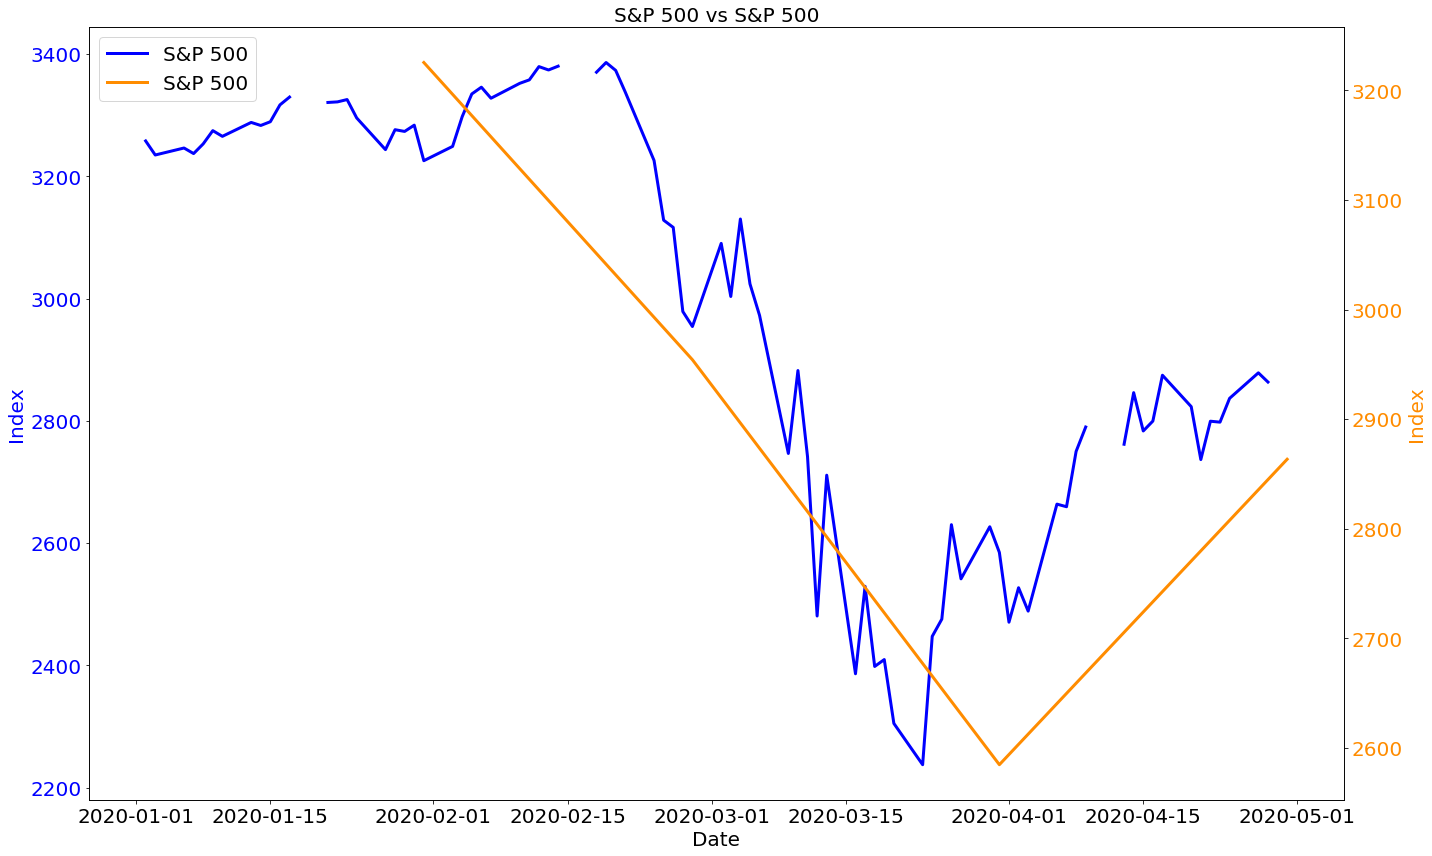

<Figure size 1440x864 with 0 Axes>

In [21]:
#create dataframe, charts and csv's for each indicator, load to AWS RDS and AWS S3
errors=[]
for indicator in tqdm_notebook(indicators):
    try:
        #get data and info series
        fred_df(indicator)
        combine_df.to_csv(f"data/{indicator}.csv",index = False, header = True)
        #export data to SQL
        combine_df.to_sql(name= indicator, con=engine, if_exists='replace', index=True)
        spx_chart = spx_month_df
        if len(spx_month_df) != len(combine_df):
            spx_chart = spx_month_df.iloc[:len(combine_df)]
        else:
            spx_chart = spx_chart

        #line chart for indicator
        plt.figure(figsize=(20,12))
        plt.plot(combine_df['date'],combine_df['data'], color = "blue", label=f"{combine_df.iloc[0,7]}", linewidth=3)
        plt.title(f"{combine_df.iloc[0,7]}", fontsize=20)
        plt.xlabel("Date", fontsize=16)
        plt.ylabel(f"{combine_df.iloc[0,12]}", fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.legend(loc="best", fontsize=16)
        plt.savefig(f"images/{indicator}_line.png")

        #indicator level vs SPX level
        fig,ax1 = plt.subplots(figsize=(20,12))
        ax1.set_title(f"{combine_df.iloc[0,7]} vs S&P 500", fontsize=20)
        ax1.set_xlabel("Date", fontsize=20)
        ax1.set_ylabel(f"{combine_df.iloc[0,12]}", fontsize=20, color="blue")
        ax1.plot(combine_df['date'],combine_df['data'], color = "blue", label=f"{combine_df.iloc[0,7]}", linewidth=3)
        ax1.tick_params(axis='y', labelcolor="blue", labelsize=20)
        ax1.tick_params(axis='x', labelsize=20)
        ax2 = ax1.twinx()
        ax2.set_ylabel(f"{spx_chart.iloc[0,12]}", fontsize=20, color="darkorange")
        ax2.plot(spx_chart['date'],spx_chart['data'], color = "darkorange", label=f"{spx_chart.iloc[0,7]}", linewidth=3)
        ax2.tick_params(axis='y', labelcolor="darkorange", labelsize=20)
        fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes, fontsize=20)
        fig.tight_layout()
        plt.savefig(f"images/{indicator}_spx_line.png")

        #run line regression
        plt.figure(figsize=(20,12))
        x_values = combine_df['pct_change']
        y_values = spx_chart['pct_change']
        (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
        regress_values = x_values * slope + intercept
        line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
        plt.scatter(x_values,y_values, color="blue")
        plt.plot(x_values,regress_values,"r-")
        plt.annotate(line_eq,(50,600),fontsize=20,color="darkorange", xycoords="axes points")
        plt.annotate(f'r = {str(round(rvalue,2))}',(50,550),fontsize=20,color="darkorange", xycoords="axes points")
        plt.title(f'{combine_df.iloc[0,7]} pct change vs S&P500 change', fontsize=20)
        plt.xlabel(f"{combine_df.iloc[0,7]}", fontsize=16)
        plt.ylabel(f"{spx_chart.iloc[0,7]}", fontsize=16)
        plt.savefig(f"images/{indicator}_spx_regress.png")
        
        #upload files to S3
        upload_to_aws(f'data/{indicator}.csv', 'astoria-adv', f'{indicator}.csv')
        upload_to_aws(f"images/{indicator}_line.png", 'astoria-adv', f"{indicator}_line.png")
        upload_to_aws(f"images/{indicator}_spx_line.png", 'astoria-adv', f"{indicator}_spx_line.png")
        upload_to_aws(f"images/{indicator}_spx_regress.png", 'astoria-adv', f"{indicator}_spx_regress.png")

        time.sleep(0.2)
        print(f'{indicator} retrieved.')
    except Exception as e: 
        print(f'error with {indicator} data. Proceeding...')
        print(e)
        errors.append(indicator)
        